## Machine Learning project
[MI-net, instance space](#section_id)
[MI-net deep supervision, instance space](#MInetdeepsuper)


In [5]:
pip install -r requirements.txt

  Cloning https://github.com/chlorochrule/cknn to /tmp/pip-req-build-wsl8xmq4
  Running command git clone --filter=blob:none --quiet https://github.com/chlorochrule/cknn /tmp/pip-req-build-wsl8xmq4
  Resolved https://github.com/chlorochrule/cknn to commit 7d05c5049da72a573bd486fca6647f8b0376243c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/garydoranjr/misvm.git to /tmp/pip-install-3fnb55yk/misvm_c76dfc420c444166aa160bbde23ddccf
  Running command git clone --filter=blob:none --quiet https://github.com/garydoranjr/misvm.git /tmp/pip-install-3fnb55yk/misvm_c76dfc420c444166aa160bbde23ddccf
  Resolved https://github.com/garydoranjr/misvm.git to commit b2118fe04d98c00436bdf8a0e4bbfb6082c5751c
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/tibovanheule/MINNs to /tmp/pip-req-build-j79qir78
  Running command git clone --filter=blob:none --quiet https://gi

Note: you may need to restart the kernel to use updated packages.


### Embedded-Space


### MI-net
<a id='section_id'></a>

In [6]:
import numpy as np
import sys
import time
import random
from random import shuffle
import argparse

from keras.models import Model
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.layers import Input, Dense, Layer, Dropout

from mil_nets.dataset import load_dataset
from mil_nets.layer import Feature_pooling
from mil_nets.metrics import bag_accuracy
from mil_nets.objectives import bag_loss
from mil_nets.utils import convertToBatch

In [83]:
def test_eval(model, test_set):
    """Evaluate on testing set.
    Parameters
    -----------------
    model : keras.engine.training.Model object
        The training MI-Net model.
    test_set : list
        A list of testing set contains all training bags features and labels.
    Returns
    -----------------
    test_loss : float
        Mean loss of evaluating on testing set.
    test_acc : float
        Mean accuracy of evaluating on testing set.
    """
    num_test_batch = len(test_set)
    result = []
    for ibatch, batch in enumerate(test_set):
        predicted = model.predict_on_batch({'input':batch[0].astype(np.float32)})[0]

        act = list(batch[1].astype(np.float32))
        if predicted > 0.5:
            result += [1]
        else:
            result += [-1]
    return result

def train_eval(model, train_set):
    """Evaluate on training set.
    Parameters
    -----------------
    model : keras.engine.training.Model object
        The training MI-Net model.
    train_set : list
        A list of training set contains all training bags features and labels.
    Returns
    -----------------
    test_loss : float
        Mean loss of evaluating on traing set..astype(np.float32)
    test_acc : float
        Mean accuracy of evaluating on testing set.
    """
    num_train_batch = len(train_set)
    train_loss = np.zeros((num_train_batch, 1), dtype=np.float32)
    train_acc = np.zeros((num_train_batch, 1), dtype=np.float32)
    shuffle(train_set)
    for ibatch, batch in enumerate(train_set):
        result = model.train_on_batch({'input':batch[0].astype(np.float32)}, {'fp':batch[1].astype(np.float32)})
        train_loss[ibatch] = result[0]
        train_acc[ibatch][0] = result[1]
    return np.mean(train_loss), np.mean(train_acc)

def MI_Net(X_train, X_test,y_train, y_test,fold):
    """Train and evaluate on MI-Net.
    Parameters
    -----------------
    dataset : dict
        A dictionary contains all dataset information. We split train/test by keys.
    Returns
    -----------------
    test_acc : float
        Testing accuracy of MI-Net.
    """
    weight_decay=0.005
    init_lr=5e-4
    pooling_mode='max'
    momentum=0.9
    max_epoch=50
    # load data and convert type
    train_set = []
    test_set = []
    
    batch_num = len(X_train)
    for ibag, bag in enumerate(X_train):
        batch_data = bag
        batch_label = np.array([y_train[ibag]]*len(bag))
        train_set.append((batch_data, batch_label))
        
    batch_num = len(X_test)
    for ibag, bag in enumerate(X_test):
        batch_data = bag
        batch_label = np.array([y_train[ibag]]*len(bag))
        test_set.append((batch_data, batch_label))
        
    dimension = train_set[0][0].shape[1]

    # data: instance feature, n*d, n = number of training instance
    data_input = Input(shape=(dimension,), dtype='float32', name='input')

    # fully-connected
    fc1 = Dense(256, activation='relu', kernel_regularizer=l2(weight_decay))(data_input)
    fc2 = Dense(128, activation='relu', kernel_regularizer=l2(weight_decay))(fc1)
    fc3 = Dense(64, activation='relu', kernel_regularizer=l2(weight_decay))(fc2)

    # dropout
    dropout = Dropout(rate=0.5)(fc3)

    # features pooling
    fp = Feature_pooling(output_dim=1, kernel_regularizer=l2(weight_decay), pooling_mode=pooling_mode, name='fp')(dropout)

    model = Model(inputs=[data_input], outputs=[fp])
    sgd = SGD(lr=init_lr, decay=1e-4, momentum=momentum, nesterov=True)
    model.compile(loss=bag_loss, optimizer=sgd, metrics=[bag_accuracy])

    # train model
    start = time.time()
    predicted = []
    for epoch in range(max_epoch):
        print("epoch",epoch)
        
        train_loss, train_acc = train_eval(model, train_set)
        predicted = test_eval(model, test_set)
    time_ep = time.time() - start
    result("MI-Net", predicted,y_test, time_ep, fold, "musk1")


run= 0   fold= 0
[(array([[-1.48097948e+00, -2.06492074e-01,  9.23010340e-02,
         8.42892171e-01, -1.41712868e+00, -1.63965717e-01,
         4.54270187e-01, -1.34686080e+00,  6.89995968e-01,
        -1.43371001e+00,  1.94881539e+00, -2.97525813e-01,
        -1.55864494e-01,  3.11583199e-01,  5.01318975e-01,
         2.05345038e-01, -4.68727219e-01, -1.51109383e+00,
         3.89747005e-01, -5.18802318e-01,  2.26220343e+00,
        -9.74607063e-01, -1.32006859e+00, -1.70689345e+00,
         1.38259922e+00,  1.00649570e+00, -1.62733340e+00,
        -1.65215541e+00, -9.00262860e-01, -1.23433495e+00,
         1.26823934e+00, -3.63923325e-01, -9.82781020e-01,
        -3.36631294e-01,  1.09735150e+00, -1.06146460e+00,
        -1.39489085e+00, -5.41435257e-01, -1.47456791e+00,
         7.49806617e-01, -1.52413081e+00,  5.04136240e-01,
        -6.43436606e-01,  1.52630409e+00,  1.87260697e-01,
         2.86318953e-01, -5.51401306e-01, -9.17234008e-01,
        -1.37988421e+00,  1.43057265e

C:\Users\seven\Documents\github\MachineLearning\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49


FileNotFoundError: [Errno 2] No such file or directory: 'compare/1671665795.png'

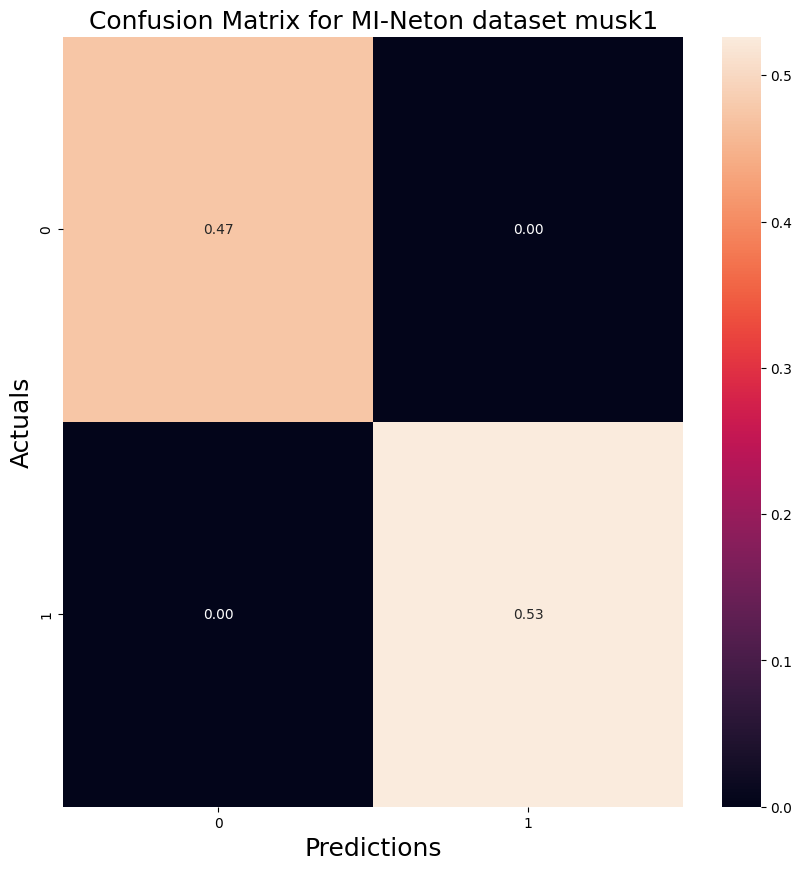

In [84]:
dataset = "musk1"
example_set = parse_c45(dataset)

# Get stats to normalize data
raw_data = np.array(example_set.to_float())
data_mean = np.average(raw_data, axis=0)
data_std  = np.std(raw_data, axis=0)
data_std[np.nonzero(data_std == 0.0)] = 1.0
def normalizer(ex):
    ex = np.array(ex)
    normed = ((ex - data_mean) / data_std)
    if dataset == "musk1":
        normed[2:-1]
    return normed[1:-1]


# Group examples into bags
bagset = bag_set(example_set)

# Convert bags to NumPy arrays
bags = [np.array(b.to_float(normalizer)) for b in bagset]
labels = np.array([b.label for b in bagset], dtype=float)
# Convert 0/1 labels to -1/1 labels
labels = 2 * labels - 1
    
# perform five times 10-fold cross-validation experiments
run = 5
n_folds = 5

labels = np.array(labels,dtype=int)

bags = np.array(bags,dtype=object)

for irun in range(run):
    fold = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
    splittt = 1
    for train_index, test_index in fold.split(bags,labels):
        X_train, X_test = bags[train_index], bags[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        print('run=', irun, '  fold=', ifold)
        MI_Net(X_train, X_test,y_train, y_test,splittt)          
        splittt += 1
            

In [3]:
from loader import parse_c45, bag_set
from __future__ import print_function, division
from sklearn.model_selection import StratifiedKFold
from score import result
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import time


### MI-net pooling deep supervision

In [ ]:
MIimport numpy as np
import sys
import time
import random
from random import shuffle
import argparse

from keras.models import Model
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.layers import Input, Dense, Layer, Dropout, average

from mil_nets.dataset import load_dataset
from mil_nets.layer import Feature_pooling
from mil_nets.metrics import bag_accuracy
from mil_nets.objectives import bag_loss
from mil_nets.utils import convertToBatch

In [61]:
def test_eval(model, test_set):
    """Evaluate on testing set.
    Parameters
    -----------------
    model : keras.engine.training.Model object
        The training MI-Net with deep supervision model.
    test_set : list
        A list of testing set contains all training bags features and labels.
    Returns
    -----------------
    test_loss : float
        Mean loss of evaluating on testing set.
    test_acc : float
        Mean accuracy of evaluating on testing set.
    """
    num_test_batch = len(test_set)
    test_loss = np.zeros((num_test_batch, 1), dtype=np.float32)
    test_acc = np.zeros((num_test_batch, 1), dtype=np.float32)
    for ibatch, batch in enumerate(test_set):
        result = model.test_on_batch({'input':batch[0].astype(np.float32)}, {'fp1':batch[1].astype(np.float32), 'fp2':batch[1].astype(np.float32), 'fp3':batch[1].astype(np.float32), 'ave':batch[1].astype(np.float32)})
        test_loss[ibatch] = result[0]
        test_acc[ibatch] = result[-1]
    return np.mean(test_loss), np.mean(test_acc)

def train_eval(model, train_set):
    """Evaluate on training set.
    Parameters
    -----------------
    model : keras.engine.training.Model object
        The training MI-Net with deep supervision model.
    train_set : list
        A list of training set contains all training bags features and labels.
    Returns
    -----------------
    test_loss : float
        Mean loss of evaluating on traing set.
    test_acc : float
        Mean accuracy of evaluating on testing set.
    """
    num_train_batch = len(train_set)
    train_loss = np.zeros((num_train_batch, 1), dtype=np.float32)
    train_acc = np.zeros((num_train_batch, 1), dtype=np.float32)
    shuffle(train_set)
    for ibatch, batch in enumerate(train_set):
        result = model.train_on_batch({'input':batch[0].astype(np.float32)}, {'fp1':batch[1].astype(np.float32), 'fp2':batch[1].astype(np.float32), 'fp3':batch[1].astype(np.float32), 'ave':batch[1].astype(np.float32)})
        train_loss[ibatch] = result[0]
        train_acc[ibatch] = result[-1]
    return np.mean(train_loss), np.mean(train_acc)

def MI_Net_with_DS(dataset):
    """Train and evaluate on MI-Net with deep supervision.
    Parameters
    -----------------
    dataset : dict
        A dictionary contains all dataset information. We split train/test by keys.
    Returns
    -----------------
    test_acc : float
        Testing accuracy of MI-Net with deep supervision.
    """
    weight_decay=0.005
    init_lr=5e-4
    pooling_mode='max'
    momentum=0.9
    max_epoch=50
    # load data and convert type
    train_bags = dataset['train']
    test_bags = dataset['test']

    # convert bag to batch
    train_set = convertToBatch(train_bags)
    test_set = convertToBatch(test_bags)
    dimension = train_set[0][0].shape[1]
    weight = [1.0, 1.0, 1.0, 0.0]

    # data: instance feature, n*d, n = number of training instance
    data_input = Input(shape=(dimension,), dtype='float32', name='input')

    # fully-connected
    fc1 = Dense(256, activation='relu', kernel_regularizer=l2(weight_decay))(data_input)
    fc2 = Dense(128, activation='relu', kernel_regularizer=l2(weight_decay))(fc1)
    fc3 = Dense(64, activation='relu', kernel_regularizer=l2(weight_decay))(fc2)

    # dropout
    dropout1 = Dropout(rate=0.5)(fc1)
    dropout2 = Dropout(rate=0.5)(fc2)
    dropout3 = Dropout(rate=0.5)(fc3)

    # features pooling
    fp1 = Feature_pooling(output_dim=1, kernel_regularizer=l2(weight_decay), pooling_mode=pooling_mode, name='fp1')(dropout1)
    fp2 = Feature_pooling(output_dim=1, kernel_regularizer=l2(weight_decay), pooling_mode=pooling_mode, name='fp2')(dropout2)
    fp3 = Feature_pooling(output_dim=1, kernel_regularizer=l2(weight_decay), pooling_mode=pooling_mode, name='fp3')(dropout3)

    # score average
    mg_ave =average([fp1,fp2,fp3], name='ave')

    model = Model(inputs=[data_input], outputs=[fp1, fp2, fp3, mg_ave])
    sgd = SGD(lr=init_lr, decay=1e-4, momentum=momentum, nesterov=True)
    model.compile(loss={'fp1':bag_loss, 'fp2':bag_loss, 'fp3':bag_loss, 'ave':bag_loss}, loss_weights={'fp1':weight[0], 'fp2':weight[1], 'fp3':weight[2], 'ave':weight[3]}, optimizer=sgd, metrics=[bag_accuracy])

    # train model
    t1 = time.time()
    num_batch = len(train_set)
    for epoch in range(max_epoch):
        train_loss, train_acc = train_eval(model, train_set)
        test_loss, test_acc = test_eval(model, test_set)
        print('epoch=', epoch, '  train_loss= {:.3f}'.format(train_loss), '  train_acc= {:.3f}'.format(train_acc), '  test_loss={:.3f}'.format(test_loss), '  test_acc= {:.3f}'.format(test_acc))
    t2 = time.time()
    print('run time:', (t2-t1) / 60, 'min')
    print('test_acc={:.3f}'.format(test_acc))

    return test_acc

In [62]:
# perform five times 10-fold cross=validation experiments
run = 5
n_folds = 10
acc = np.zeros((run, n_folds), dtype=float)
for irun in range(run):
    dataset = load_dataset('musk1', n_folds)
    for ifold in range(n_folds):
        print('run=', irun, '  fold=', ifold)
        acc[irun][ifold] = MI_Net_with_DS(dataset[ifold])
print('MI-Net with DS mean accuracy = ', np.mean(acc))
print('std = ', np.std(acc))

run= 0   fold= 0
[(array([[ 0.18091303, -0.8825274 , -0.4306278 , -1.2050301 , -0.16396575,
         0.22583246,  0.37227392, -1.264914  ,  0.6552512 ,  0.6779485 ,
        -1.5364    , -1.7125827 ,  0.08501184, -2.0605624 , -2.367217  ,
        -0.5470899 , -0.13566388, -0.05415298, -1.8799821 , -1.9624486 ,
         0.09283514,  0.52116567,  0.08028498,  0.6574811 ,  1.3694118 ,
         1.025903  , -0.02639023, -0.44556934,  0.38590392,  0.8780831 ,
        -0.36392334, -1.0787079 , -0.6088972 ,  1.2323903 , -1.0991892 ,
        -1.2969388 , -0.5764164 ,  1.2886021 , -0.93142754,  0.9640146 ,
        -0.9577945 , -1.2128909 ,  0.5915717 , -2.0312877 , -2.1559346 ,
        -1.1366371 , -0.6786122 ,  1.1662757 , -1.6219761 , -0.440266  ,
        -0.7766783 ,  0.4563761 ,  0.53716654, -0.93409586,  1.28761   ,
         1.0996368 ,  0.30686286, -0.77745533,  0.3906427 ,  1.2607541 ,
        -0.9363774 , -1.0160574 ,  0.5418985 ,  0.44343278, -1.3057879 ,
        -0.27241987, -0.14577623

NameError: name 'average' is not defined

## Bag-Space

In [ ]:
import pandas as pd
X = pd.read_table("./clean2.data") #pd.read_csv("sample_data/mnist_test.csv") 

In [ ]:
from cknn import cknneighbors_graph

#ckng = cknneighbors_graph(X, n_neighbors=5, delta=1.0)

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import seaborn as sns

from cknn import cknneighbors_graph

sns.set()


def plot2d_label(X, title=None):
    digits = load_digits()
    y = digits.target
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()


def main():
    data = X
    print(data)
    n_neighbors = 2

    model_normal = SpectralEmbedding(n_components=2, n_neighbors=n_neighbors)
    y_normal = model_normal.fit_transform(data)
    plot2d_label(y_normal)

    #ckng = cknneighbors_graph(data, n_neighbors=n_neighbors, delta=1.5)
    #model_cknn = SpectralEmbedding(n_components=2, affinity='precomputed')
    #y_cknn = model_cknn.fit_transform(ckng.toarray())
    #plot2d_label(y_cknn)

main()

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import seaborn as sns

sns.set()


def plot2d_label(X, title=None):
    y = X[1]
    x_min, x_max = np.min(X[0], 0), np.max(X[0], 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()


def main():
    data = X
    n_neighbors = 10

    model_normal = SpectralEmbedding(n_components=2, n_neighbors=n_neighbors)
    y_normal = model_normal.fit_transform(data)
    #plot2d_label(y_normal)

    ckng = cknneighbors_graph(data, n_neighbors=n_neighbors, delta=1.5)
    model_cknn = SpectralEmbedding(n_components=2, affinity='precomputed')
    y_cknn = model_cknn.fit_transform(ckng.toarray())
    #plot2d_label(y_cknn)
    print(y_cknn)

main()

## instance-Space


MI-SVM and mi-SVM

In [36]:
import misvm
import time
from loader import parse_c45, bag_set
from score import result
from __future__ import print_function, division
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [2]:
# Load list of C4.5 Examples

for dataset in ['fox','mutagenesis-atoms','mutagenesis-bonds','mutagenesis-chains','eastWest','elephant','tiger','westEast', 'musk1']:
    example_set = parse_c45(dataset)


    # Get stats to normalize data
    raw_data = np.array(example_set.to_float())
    data_mean = np.average(raw_data, axis=0)
    data_std  = np.std(raw_data, axis=0)
    data_std[np.nonzero(data_std == 0.0)] = 1.0
    def normalizer(ex):
        ex = np.array(ex)
        normed = ((ex - data_mean) / data_std)
        # The ...[:, 2:-1] removes first two columns and last column,
        # which are the bag/instance ids and class label, as part of the
        # normalization process
        if dataset == "musk1":
            normed[2:-1]
        return normed[1:-1]


    # Group examples into bags
    bagset = bag_set(example_set)

    # Convert bags to NumPy arrays
    bags = [np.array(b.to_float(normalizer)) for b in bagset]
    labels = np.array([b.label for b in bagset], dtype=float)
    # Convert 0/1 labels to -1/1 labels
    labels = 2 * labels - 1

    # Construct classifiers
    classifiers = {}

    # MISVM   : the MI-SVM algorithm of Andrews, Tsochantaridis, & Hofmann (2002)
    # miSVM   : the mi-SVM algorithm of Andrews, Tsochantaridis, & Hofmann (2002)

    #  : the semi-supervised learning approach of Zhou & Xu (2007)
    #     : the MI classification algorithm of Mangasarian & Wild (2008)
    # sMIL    : sparse MIL (Bunescu & Mooney, 2007)
    # stMIL   : sparse, transductive  MIL (Bunescu & Mooney, 2007)

    classifiers['MissSVM'] = misvm.MissSVM(kernel='linear', C=1.0, max_iters=20)
    classifiers['sbMIL'] = misvm.sbMIL(kernel='linear', eta=0.1, C=1e2)
    classifiers['SIL'] = misvm.SIL(kernel='linear', C=1.0)
    classifiers['STK'] = misvm.STK(kernel='linear', C=1.0)
    classifiers['NSK'] = misvm.NSK(kernel='linear', C=1.0)
    classifiers['MICA'] = misvm.MICA(kernel='linear', C=1.0)

    # Train/Evaluate classifiers
    accuracies = {}

    bags = np.array(bags,dtype=object)
    labels = np.array(labels,dtype=int)
    fold = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
    for algorithm, classifier in classifiers.items():
        nums = 1
        start = time.time()
        for train_index, test_index in fold.split(bags,labels):
            X_train, X_test = bags[train_index], bags[test_index]
            y_train, y_test = labels[train_index], labels[test_index]

            classifier.fit(X_train, y_train)
            predictions = classifier.predict(X_test)
            for i, pred in enumerate(predictions):
                if pred < 0:
                    predictions[i] = -1
                else:
                    predictions[i] = 1
            time_ep = time.time() - start
            print(algorithm, dataset)
            print(y_test)
            print(predictions)
            result(algorithm, y_test, predictions, time_ep, nums, dataset)
            accuracies[algorithm + " " + str(nums)] = {"acc":np.average(y_test == np.sign(predictions)),"kfold":nums}
            nums+=1

    for algorithm, item in accuracies.items():
        print('\n%s, fold:%s Accuracy: %.f%%' % (algorithm,str(item["kfold"]), 100 * item["acc"]))

Non-random start...
     pcost       dcost       gap    pres   dres
 0: -5.9252e+02 -2.3541e+01  1e+04  1e+02  1e-12
 1: -1.9258e+01 -2.3349e+01  2e+02  2e+00  2e-12
 2: -7.6660e+00 -1.8961e+01  3e+01  2e-01  2e-13
 3: -6.2594e+00 -1.4060e+01  1e+01  8e-02  7e-14
 4: -6.0995e+00 -8.8670e+00  3e+00  1e-02  3e-14
 5: -6.5359e+00 -7.1598e+00  7e-01  3e-03  3e-14
 6: -6.6992e+00 -6.8975e+00  2e-01  6e-04  3e-14
 7: -6.7499e+00 -6.8230e+00  8e-02  2e-04  2e-14
 8: -6.7741e+00 -6.7893e+00  2e-02  3e-05  3e-14
 9: -6.7795e+00 -6.7823e+00  3e-03  4e-06  3e-14
10: -6.7807e+00 -6.7808e+00  2e-04  1e-07  3e-14
11: -6.7807e+00 -6.7808e+00  7e-06  4e-09  3e-14
12: -6.7807e+00 -6.7807e+00  1e-07  7e-11  3e-14
Optimal solution found.

Iteration 1...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.9261e+02 -2.3417e+01  1e+04  1e+02  2e-12
 1: -2.1612e+01 -2.3190e+01  3e+02  3e+00  1e-12
 2: -7.8412e+00 -1.8892e+01  5e+0

Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.9183e+02 -2.3275e+01  1e+04  1e+02  1e-12
 1: -2.2162e+01 -2.3069e+01  3e+02  3e+00  1e-12
 2: -7.6879e+00 -1.9006e+01  4e+01  3e-01  2e-13
 3: -6.0554e+00 -1.2785e+01  1e+01  9e-02  5e-14
 4: -5.7847e+00 -8.1898e+00  3e+00  1e-02  3e-14
 5: -6.0438e+00 -7.1983e+00  2e+00  6e-03  3e-14
 6: -6.2405e+00 -6.6035e+00  4e-01  1e-03  3e-14
 7: -6.2906e+00 -6.5014e+00  3e-01  6e-04  3e-14
 8: -6.3408e+00 -6.4031e+00  7e-02  9e-05  3e-14
 9: -6.3566e+00 -6.3788e+00  3e-02  3e-05  3e-14
10: -6.3640e+00 -6.3676e+00  4e-03  3e-06  3e-14
11: -6.3654e+00 -6.3657e+00  4e-04  2e-07  3e-14
12: -6.3655e+00 -6.3655e+00  2e-05  1e-08  3e-14
13: -6.3655e+00 -6.3655e+00  4e-07  2e-10  3e-14
Optimal solution found.
delta obj ratio: 3.72e+04

Iteration 11...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.9235e+02 -2.3275e+01  1e+04  1e+02  2e-12
 1: -2.1213e

10: -6.4888e+00 -6.4894e+00  7e-04  8e-07  3e-14
11: -6.4891e+00 -6.4891e+00  2e-05  3e-08  3e-14
12: -6.4891e+00 -6.4891e+00  5e-07  5e-10  3e-14
Optimal solution found.
delta obj ratio: 1.68e+05

Iteration 20...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.9310e+02 -2.3162e+01  1e+04  1e+02  2e-12
 1: -2.0507e+01 -2.2950e+01  3e+02  3e+00  2e-12
 2: -7.5445e+00 -1.8637e+01  4e+01  3e-01  2e-13
 3: -5.9668e+00 -1.2078e+01  1e+01  7e-02  5e-14
 4: -5.9347e+00 -7.6672e+00  2e+00  1e-02  3e-14
 5: -6.2216e+00 -6.7196e+00  6e-01  3e-03  3e-14
 6: -6.3421e+00 -6.4893e+00  2e-01  6e-04  3e-14
 7: -6.3824e+00 -6.4245e+00  5e-02  1e-04  3e-14
 8: -6.3953e+00 -6.4058e+00  1e-02  2e-05  3e-14
 9: -6.3989e+00 -6.4010e+00  2e-03  4e-06  3e-14
10: -6.3996e+00 -6.4000e+00  5e-04  8e-07  3e-14
11: -6.3997e+00 -6.3998e+00  2e-05  2e-08  3e-14
12: -6.3998e+00 -6.3998e+00  8e-07  9e-10  3e-14
Optimal solution found.
d

MissSVM tiger
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ 1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1. -1. -1. -1.]
Non-random start...
     pcost       dcost       gap    pres   dres
 0: -5.7707e+02 -2.3775e+01  1e+04  1e+02  2e-12
 1: -1.6961e+01 -2.3530e+01  2e+02  2e+00  1e-12
 2: -7.3671e+00 -1.8561e+01  3e+01  2e-01  2e-13
 3: -6.1027e+00 -1.2849e+01  1e+01  7e-02  5e-14
 4: -5.9609e+00 -8.2946e+00  3e+00  1e-02  3e-14
 5: -6.3226e+00 -6.9894e+00  7e-01  3e-03  2e-14
 6: -6.4749e+00 -6.6833e+00  2e-01  5e-04  2e-14
 7: -6.5291e+00 -6.5935e+00  7e-02  1e-04  2e-14
 8: -6.5470e+00 -6.5660e+00  2e-02  2e-05  3e-14
 9: -6.5537e+00 -6.5569e+00  3e-03  4e-06  3e-14
10: -6.5549e+00 -6.5553e+00  4e-04  2e-07  3e-14
11: -6.5550e+00 -6.5551e+00  1e-05  9e-10  3e-14
12: -6.5551e+00 -6.5551e+00  2e-07  1e-11  

Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.7694e+02 -2.3506e+01  1e+04  1e+02  2e-12
 1: -1.6286e+01 -2.3243e+01  2e+02  2e+00  1e-12
 2: -7.2467e+00 -1.8138e+01  4e+01  3e-01  2e-13
 3: -6.0347e+00 -1.2743e+01  1e+01  8e-02  7e-14
 4: -6.1412e+00 -7.5212e+00  2e+00  8e-03  3e-14
 5: -6.4095e+00 -6.9211e+00  7e-01  3e-03  3e-14
 6: -6.5164e+00 -6.7339e+00  3e-01  8e-04  3e-14
 7: -6.5628e+00 -6.6595e+00  1e-01  3e-04  3e-14
 8: -6.5812e+00 -6.6320e+00  6e-02  1e-04  3e-14
 9: -6.5947e+00 -6.6124e+00  2e-02  4e-05  3e-14
10: -6.6009e+00 -6.6038e+00  3e-03  5e-06  3e-14
11: -6.6019e+00 -6.6024e+00  6e-04  8e-07  3e-14
12: -6.6021e+00 -6.6022e+00  2e-05  2e-08  3e-14
13: -6.6021e+00 -6.6021e+00  4e-07  3e-10  3e-14
Optimal solution found.
delta obj ratio: 2.56e+05

Iteration 11...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.7497e+02 -2.3513e+01  1e+04  1e+02  1e-12
 1: -1.5997e

13: -6.7836e+00 -6.7836e+00  3e-05  2e-08  3e-14
14: -6.7836e+00 -6.7836e+00  4e-07  2e-10  3e-14
Optimal solution found.
delta obj ratio: 5.29e+05

Iteration 20...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.7515e+02 -2.3488e+01  1e+04  1e+02  2e-12
 1: -1.6209e+01 -2.3222e+01  2e+02  2e+00  2e-12
 2: -7.2025e+00 -1.7977e+01  3e+01  3e-01  2e-13
 3: -6.1170e+00 -1.2832e+01  1e+01  9e-02  8e-14
 4: -6.0719e+00 -7.6636e+00  2e+00  1e-02  3e-14
 5: -6.3800e+00 -6.8438e+00  6e-01  3e-03  3e-14
 6: -6.4937e+00 -6.6459e+00  2e-01  6e-04  3e-14
 7: -6.5343e+00 -6.5824e+00  6e-02  1e-04  3e-14
 8: -6.5489e+00 -6.5618e+00  2e-02  3e-05  3e-14
 9: -6.5528e+00 -6.5565e+00  4e-03  7e-06  3e-14
10: -6.5541e+00 -6.5547e+00  6e-04  5e-07  3e-14
11: -6.5544e+00 -6.5544e+00  2e-05  2e-08  3e-14
12: -6.5544e+00 -6.5544e+00  5e-07  4e-10  3e-14
Optimal solution found.
delta obj ratio: 2.29e+05


MissSVM tiger
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.
  1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.]
Non-random start...
     pcost       dcost       gap    pres   dres
 0: -5.6655e+02 -2.3247e+01  1e+04  1e+02  1e-12
 1: -1.8022e+01 -2.3025e+01  2e+02  2e+00  1e-12
 2: -7.3073e+00 -1.8588e+01  3e+01  2e-01  2e-13
 3: -6.0394e+00 -1.2910e+01  1e+01  7e-02  5e-14
 4: -5.8871e+00 -8.5576e+00  3e+00  2e-02  3e-14
 5: -6.2622e+00 -6.8454e+00  7e-01  3e-03  2e-14
 6: -6.3970e+00 -6.6198e+00  2e-01  9e-04  2e-14
 7: -6.4408e+00 -6.5501e+00  1e-01  3e-04  2e-14
 8: -6.4747e+00 -6.4997e+00  3e-02  7e-05  3e-14
 9: -6.4834e+00 -6.4873e+00  4e-03  4e-06  3e-14
10: -6.4850e+00 -6.4854e+00  3e-04  3e-07  3e-14
11: -6.4852e+00 -6.4852e+00  9e-06  7e-09  3e-14
12: -6.4852e+00 -6.4852e+00  5e-07  3e-10  

10: -6.6317e+00 -6.6321e+00  4e-04  3e-07  3e-14
11: -6.6319e+00 -6.6319e+00  3e-05  2e-08  3e-14
12: -6.6319e+00 -6.6319e+00  5e-07  3e-10  3e-14
Optimal solution found.
delta obj ratio: 1.94e+05

Iteration 10...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.6938e+02 -2.3070e+01  1e+04  1e+02  1e-12
 1: -1.7845e+01 -2.2833e+01  2e+02  2e+00  1e-12
 2: -7.5403e+00 -1.8329e+01  4e+01  3e-01  2e-13
 3: -6.2034e+00 -1.2413e+01  1e+01  8e-02  6e-14
 4: -6.1618e+00 -7.6163e+00  2e+00  8e-03  3e-14
 5: -6.3734e+00 -7.0776e+00  9e-01  4e-03  3e-14
 6: -6.4916e+00 -6.8094e+00  4e-01  6e-04  3e-14
 7: -6.5622e+00 -6.6823e+00  1e-01  2e-04  3e-14
 8: -6.5944e+00 -6.6294e+00  4e-02  4e-05  3e-14
 9: -6.6054e+00 -6.6127e+00  8e-03  3e-06  3e-14
10: -6.6081e+00 -6.6092e+00  1e-03  4e-07  3e-14
11: -6.6086e+00 -6.6086e+00  5e-05  1e-08  3e-14
12: -6.6086e+00 -6.6086e+00  1e-06  2e-10  3e-14
Optimal solution found.
d

10: -6.6236e+00 -6.6244e+00  9e-04  1e-06  3e-14
11: -6.6239e+00 -6.6240e+00  4e-05  5e-08  3e-14
12: -6.6240e+00 -6.6240e+00  2e-06  3e-09  3e-14
Optimal solution found.
delta obj ratio: 1.84e+05

Iteration 20...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.6924e+02 -2.3241e+01  1e+04  1e+02  1e-12
 1: -1.8481e+01 -2.2992e+01  2e+02  2e+00  1e-12
 2: -7.6781e+00 -1.8684e+01  4e+01  3e-01  2e-13
 3: -6.1470e+00 -1.2350e+01  1e+01  7e-02  5e-14
 4: -6.2195e+00 -7.5202e+00  2e+00  5e-03  3e-14
 5: -6.5176e+00 -6.9485e+00  5e-01  1e-03  3e-14
 6: -6.6079e+00 -6.8164e+00  2e-01  6e-04  3e-14
 7: -6.6547e+00 -6.7482e+00  1e-01  2e-04  2e-14
 8: -6.6821e+00 -6.7094e+00  3e-02  5e-05  3e-14
 9: -6.6904e+00 -6.6984e+00  9e-03  1e-05  3e-14
10: -6.6933e+00 -6.6947e+00  2e-03  2e-06  3e-14
11: -6.6939e+00 -6.6939e+00  1e-04  1e-07  3e-14
12: -6.6939e+00 -6.6939e+00  3e-06  3e-09  3e-14
Optimal solution found.
d

MissSVM tiger
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1. -1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1.
 -1.  1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.
 -1. -1. -1. -1.]
Non-random start...
     pcost       dcost       gap    pres   dres
 0: -5.7309e+02 -2.3375e+01  1e+04  1e+02  1e-12
 1: -2.0740e+01 -2.3182e+01  3e+02  3e+00  2e-12
 2: -7.5523e+00 -1.9123e+01  4e+01  3e-01  2e-13
 3: -6.1430e+00 -1.3556e+01  1e+01  1e-01  7e-14
 4: -5.7787e+00 -9.0675e+00  4e+00  2e-02  3e-14
 5: -6.1008e+00 -6.8022e+00  8e-01  4e-03  2e-14
 6: -6.2617e+00 -6.5013e+00  3e-01  1e-03  2e-14
 7: -6.3158e+00 -6.4133e+00  1e-01  3e-04  2e-14
 8: -6.3436e+00 -6.3711e+00  3e-02  7e-05  2e-14
 9: -6.3531e+00 -6.3578e+00  5e-03  7e-06  3e-14
10: -6.3549e+00 -6.3556e+00  7e-04  7e-07  3e-14
11: -6.3552e+00 -6.3552e+00  3e-05  3e-08  3e-14
12: -6.3552e+00 -6.3552e+00  9e-07  6e-10  

Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.7186e+02 -2.3124e+01  1e+04  1e+02  1e-12
 1: -2.0355e+01 -2.2920e+01  3e+02  3e+00  2e-12
 2: -7.4638e+00 -1.8659e+01  4e+01  3e-01  2e-13
 3: -5.7879e+00 -1.2948e+01  1e+01  8e-02  6e-14
 4: -5.8844e+00 -7.7715e+00  3e+00  1e-02  3e-14
 5: -6.2004e+00 -6.7712e+00  8e-01  3e-03  3e-14
 6: -6.2755e+00 -6.6294e+00  5e-01  2e-03  3e-14
 7: -6.3558e+00 -6.4823e+00  2e-01  5e-04  3e-14
 8: -6.3882e+00 -6.4282e+00  5e-02  1e-04  3e-14
 9: -6.3973e+00 -6.4130e+00  2e-02  1e-05  3e-14
10: -6.4026e+00 -6.4061e+00  4e-03  3e-06  3e-14
11: -6.4040e+00 -6.4043e+00  3e-04  2e-07  3e-14
12: -6.4041e+00 -6.4041e+00  1e-05  6e-09  3e-14
13: -6.4041e+00 -6.4041e+00  2e-07  8e-11  3e-14
Optimal solution found.
delta obj ratio: 1.40e+05

Iteration 11...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.7168e+02 -2.3194e+01  1e+04  1e+02  1e-12
 1: -2.1974e

12: -6.4464e+00 -6.4464e+00  9e-07  1e-10  3e-14
Optimal solution found.
delta obj ratio: 6.42e+04

Iteration 20...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.7393e+02 -2.3274e+01  1e+04  1e+02  1e-12
 1: -2.0425e+01 -2.3073e+01  3e+02  3e+00  2e-12
 2: -7.4377e+00 -1.8865e+01  4e+01  3e-01  2e-13
 3: -6.0963e+00 -1.2588e+01  1e+01  8e-02  6e-14
 4: -6.1066e+00 -7.6877e+00  2e+00  1e-02  3e-14
 5: -6.4002e+00 -6.8385e+00  6e-01  3e-03  3e-14
 6: -6.5006e+00 -6.6652e+00  2e-01  7e-04  3e-14
 7: -6.5330e+00 -6.6154e+00  1e-01  3e-04  3e-14
 8: -6.5566e+00 -6.5802e+00  3e-02  8e-05  3e-14
 9: -6.5644e+00 -6.5690e+00  5e-03  1e-05  3e-14
10: -6.5661e+00 -6.5668e+00  8e-04  8e-07  3e-14
11: -6.5664e+00 -6.5664e+00  6e-05  6e-08  3e-14
12: -6.5664e+00 -6.5664e+00  2e-06  2e-09  3e-14
Optimal solution found.
delta obj ratio: 1.20e+05


MissSVM tiger
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1. -1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.
 -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.]
Non-random start...
     pcost       dcost       gap    pres   dres
 0: -5.6788e+02 -2.3091e+01  1e+04  1e+02  2e-12
 1: -2.2048e+01 -2.2881e+01  3e+02  3e+00  1e-12
 2: -7.7929e+00 -1.9220e+01  4e+01  3e-01  2e-13
 3: -6.0893e+00 -1.3427e+01  1e+01  9e-02  5e-14
 4: -5.7771e+00 -9.3476e+00  5e+00  2e-02  3e-14
 5: -6.1445e+00 -6.9379e+00  9e-01  5e-03  2e-14
 6: -6.3271e+00 -6.5956e+00  3e-01  1e-03  2e-14
 7: -6.3904e+00 -6.4941e+00  1e-01  4e-04  2e-14
 8: -6.4177e+00 -6.4523e+00  4e-02  8e-05  2e-14
 9: -6.4289e+00 -6.4371e+00  9e-03  1e-05  2e-14
10: -6.4323e+00 -6.4328e+00  5e-04  6e-07  3e-14
11: -6.4325e+00 -6.4326e+00  5e-05  5e-08  3e-14
12: -6.4325e+00 -6.4325e+00  1e-06  1e-09  

Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.6758e+02 -2.2842e+01  1e+04  1e+02  1e-12
 1: -2.1115e+01 -2.2632e+01  3e+02  3e+00  1e-12
 2: -7.6165e+00 -1.8658e+01  4e+01  3e-01  2e-13
 3: -6.0809e+00 -1.2161e+01  1e+01  8e-02  5e-14
 4: -5.9784e+00 -7.4926e+00  2e+00  8e-03  3e-14
 5: -6.2875e+00 -6.7172e+00  5e-01  2e-03  3e-14
 6: -6.3822e+00 -6.5610e+00  2e-01  7e-04  3e-14
 7: -6.4342e+00 -6.4811e+00  6e-02  1e-04  3e-14
 8: -6.4473e+00 -6.4625e+00  2e-02  3e-05  3e-14
 9: -6.4524e+00 -6.4557e+00  4e-03  5e-06  3e-14
10: -6.4536e+00 -6.4541e+00  6e-04  7e-07  3e-14
11: -6.4538e+00 -6.4538e+00  2e-05  2e-08  3e-14
12: -6.4538e+00 -6.4538e+00  4e-07  4e-10  3e-14
Optimal solution found.
delta obj ratio: 3.56e+05

Iteration 11...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.6885e+02 -2.2910e+01  1e+04  1e+02  2e-12
 1: -2.0244e+01 -2.2697e+01  3e+02  3e+00  1e-12
 2: -7.5732e

Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.6866e+02 -2.3143e+01  1e+04  1e+02  1e-12
 1: -2.1545e+01 -2.2928e+01  3e+02  3e+00  1e-12
 2: -7.3829e+00 -1.8959e+01  4e+01  3e-01  2e-13
 3: -6.0177e+00 -1.2853e+01  1e+01  7e-02  4e-14
 4: -6.2468e+00 -7.7797e+00  2e+00  9e-03  3e-14
 5: -6.5700e+00 -7.0109e+00  6e-01  2e-03  3e-14
 6: -6.6806e+00 -6.8309e+00  2e-01  3e-04  3e-14
 7: -6.7175e+00 -6.7760e+00  7e-02  1e-04  3e-14
 8: -6.7357e+00 -6.7493e+00  2e-02  2e-05  3e-14
 9: -6.7404e+00 -6.7429e+00  3e-03  2e-06  3e-14
10: -6.7413e+00 -6.7417e+00  4e-04  2e-07  3e-14
11: -6.7415e+00 -6.7415e+00  2e-05  1e-08  3e-14
12: -6.7415e+00 -6.7415e+00  2e-06  1e-09  3e-14
Optimal solution found.
delta obj ratio: 9.71e+04


MissSVM tiger
[ 1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1]
[-1.  1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1. -1.
  1.  1.  1.  1.]
Training initial sMIL classifier for sbMIL...
Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -4.3931e+00 -3.6706e+02  4e+03  4e+00  2e-13
 1: -1.9992e+00 -2.3066e+02  6e+02  4e-01  1e-13
 2: -4.2059e-01 -7.5916e+01  1e+02  5e-02  8e-14
 3: -6.4936e-02 -2.0009e+01  3e+01  1e-02  2e-14
 4:  9.2564e-02 -5.7765e+00  8e+00  2e-03  1e-14
 5:  5.3826e-02 -6.6162e-01  8e-01  2e-04  2e-15
 6:  3.9802e-03 -2.2286e-01  2e-01  5e-05  2e-15
 7: -3.1829e-03 -1.7630e-01  2e-01  2e-05  1e-15
 8: -1.8839e-02 -1.0155e-01  8e-02  8e-06  1e-15
 9: -2.7152e-02 -7.1097e-02  4e-02  2e-16  9e-16
10: -3.4182e-02 -5.2940e-02  2e-02  2e-16  8e-16
11: -3.8206e-02 -4.4262e-02  6e-03  2e-1

Training initial sMIL classifier for sbMIL...
Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -4.6518e+00 -3.6924e+02  4e+03  4e+00  2e-13
 1: -2.2616e+00 -2.3215e+02  6e+02  4e-01  1e-13
 2: -6.9623e-01 -8.0799e+01  1e+02  7e-02  7e-14
 3:  7.4353e-03 -1.3947e+01  2e+01  9e-03  2e-14
 4:  6.9739e-02 -2.5687e+00  4e+00  1e-03  5e-15
 5:  5.1478e-02 -5.2443e-01  7e-01  1e-04  5e-15
 6:  2.9699e-03 -3.6705e-02  4e-02  2e-06  2e-15
 7: -2.5322e-03 -2.9019e-02  3e-02  1e-06  1e-15
 8: -8.8280e-03 -2.6202e-02  2e-02  2e-07  9e-16
 9: -1.2159e-02 -2.2866e-02  1e-02  2e-16  8e-16
10: -1.3724e-02 -1.8550e-02  5e-03  2e-16  1e-15
11: -1.4281e-02 -1.7102e-02  3e-03  2e-16  9e-16
12: -1.5248e-02 -1.5557e-02  3e-04  2e-16  1e-15
13: -1.5384e-02 -1.5395e-02  1e-05  2e-16  1e-15
14: -1.5389e-02 -1.5389e-02  1e-07  2e-16  1e-15
15: -1.5389e-02 -1.5389e-02  1e-09  2e-16  9e-16
Optimal solution found.
Computing initial instance labels for sbMIL...
Retraining with top 10% a

     pcost       dcost       gap    pres   dres
 0: -6.9752e+00 -3.1679e+00  9e+02  3e+01  5e-14
 1: -1.7538e+00 -2.3221e+00  4e+01  1e+00  5e-14
 2: -4.6846e-01 -1.8352e+00  4e+00  8e-02  1e-14
 3: -3.4052e-01 -9.0555e-01  6e-01  3e-03  3e-15
 4: -3.6969e-01 -4.6025e-01  9e-02  4e-04  3e-15
 5: -3.8829e-01 -4.0989e-01  2e-02  7e-05  3e-15
 6: -3.9410e-01 -3.9671e-01  3e-03  5e-06  3e-15
 7: -3.9498e-01 -3.9513e-01  2e-04  2e-07  3e-15
 8: -3.9503e-01 -3.9504e-01  6e-06  5e-09  3e-15
 9: -3.9504e-01 -3.9504e-01  2e-07  6e-11  3e-15
Optimal solution found.
STK tiger
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.
  1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1.  1.
 -1. -1. -1. -1.]
     pcost       dcost       gap    pres   dres
 0: -5.6547e+00 -2.7820e+00  7e+02  3e+01  4e-14
 1: -1.5034e+00 -2.0397e+00  3e+01  1e+00  4

C:\Users\seven\Documents\github\MachineLearning\score.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7.5, 7.5))


Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.4394e+01 -1.9553e+00  7e+02  3e+01  9e-13
 1: -8.6118e-01 -1.7124e+00  2e+01  9e-01  9e-13
 2: -2.8859e-01 -1.4516e+00  3e+00  9e-02  1e-13
 3: -2.0030e-01 -7.9297e-01  9e-01  2e-02  2e-14
 4: -1.8584e-01 -3.8378e-01  2e-01  4e-03  2e-14
 5: -1.9601e-01 -2.3741e-01  5e-02  5e-04  2e-14
 6: -2.0286e-01 -2.1155e-01  9e-03  8e-05  1e-14
 7: -2.0469e-01 -2.0664e-01  2e-03  1e-05  1e-14
 8: -2.0523e-01 -2.0541e-01  2e-04  6e-07  1e-14
 9: -2.0529e-01 -2.0529e-01  6e-06  2e-08  1e-14
10: -2.0529e-01 -2.0529e-01  1e-07  3e-10  2e-14
Optimal solution found.
NSK tiger
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ 1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1.
 -1.  1.  1.  1.]
Setup QP...
Solving QP...
     pcost       dcost       gap    pres

21: -6.2826e-01 -6.2974e-01  1e-03  8e-17  2e-01
22: -6.2891e-01 -6.3048e-01  2e-03  1e-16  2e-01
23: -6.3085e-01 -6.3266e-01  2e-03  8e-17  1e-01
24: -6.3162e-01 -6.3348e-01  2e-03  1e-16  1e-01
25: -6.3254e-01 -6.3431e-01  2e-03  9e-17  9e-02
26: -6.3301e-01 -6.3482e-01  2e-03  8e-17  7e-02
27: -6.3335e-01 -6.3513e-01  2e-03  2e-16  5e-02
28: -6.3364e-01 -6.3530e-01  2e-03  1e-16  4e-02
29: -6.3402e-01 -6.3550e-01  1e-03  4e-17  1e-02
30: -6.3450e-01 -6.3504e-01  5e-04  2e-16  1e-03
31: -6.3475e-01 -6.3476e-01  2e-05  2e-16  3e-05
32: -6.3475e-01 -6.3475e-01  2e-07  2e-16  4e-07
33: -6.3475e-01 -6.3475e-01  2e-09  9e-17  4e-09
Optimal solution found.
Update LP...
Solve LP...
delta obj ratio: 2.47e+06

Iteration 4...
Update QP...
Solve QP...
     pcost       dcost       gap    pres   dres
 0: -6.3096e-01 -6.3096e-01  2e-09  9e-17  9e-02
 1: -6.3203e-01 -6.3203e-01  9e-09  5e-17  6e-02
 2: -6.3204e-01 -6.3204e-01  9e-09  7e-17  6e-02
 3: -6.3203e-01 -6.3203e-01  2e-06  5e-17  6e-02
 4:

 5: -6.1966e-01 -6.1982e-01  2e-04  3e-15  8e-02
 6: -6.2024e-01 -6.2041e-01  2e-04  2e-15  5e-02
 7: -6.2023e-01 -6.2043e-01  2e-04  2e-15  5e-02
 8: -6.2021e-01 -6.2043e-01  2e-04  2e-15  5e-02
 9: -6.2047e-01 -6.2091e-01  4e-04  2e-15  4e-02
10: -6.2054e-01 -6.2096e-01  4e-04  1e-15  3e-02
11: -6.2066e-01 -6.2104e-01  4e-04  1e-16  4e-03
12: -6.2082e-01 -6.2085e-01  3e-05  2e-16  3e-04
13: -6.2083e-01 -6.2083e-01  6e-07  1e-16  4e-06
14: -6.2083e-01 -6.2083e-01  9e-09  8e-17  5e-08
Optimal solution found.
Update LP...
Solve LP...
delta obj ratio: 2.45e+06

Iteration 5...
Update QP...
Solve QP...
     pcost       dcost       gap    pres   dres
 0: -6.1748e-01 -6.1748e-01  9e-09  8e-17  9e-02
 1: -6.1765e-01 -6.1767e-01  1e-05  4e-17  8e-02
 2: -6.1767e-01 -6.1768e-01  1e-05  2e-16  8e-02
 3: -6.1803e-01 -6.1805e-01  1e-05  3e-16  7e-02
 4: -6.1806e-01 -6.1817e-01  1e-04  3e-16  7e-02
 5: -6.1812e-01 -6.1824e-01  1e-04  3e-16  6e-02
 6: -6.1827e-01 -6.1841e-01  1e-04  3e-16  6e-02
 7:

18: -5.8370e-01 -5.8370e-01  9e-08  9e-17  1e-06
19: -5.8370e-01 -5.8370e-01  1e-09  1e-16  1e-08
Optimal solution found.
Update LP...
Solve LP...
delta obj ratio: 1.44e+06

Iteration 5...
Update QP...
Solve QP...
     pcost       dcost       gap    pres   dres
 0: -5.8205e-01 -5.8205e-01  1e-09  1e-16  5e-02
 1: -5.8207e-01 -5.8207e-01  1e-09  4e-17  5e-02
 2: -5.8209e-01 -5.8209e-01  1e-06  1e-16  5e-02
 3: -5.8210e-01 -5.8210e-01  2e-06  3e-16  5e-02
 4: -5.8210e-01 -5.8236e-01  3e-04  3e-16  5e-02
 5: -5.8232e-01 -5.8257e-01  3e-04  1e-14  4e-02
 6: -5.8259e-01 -5.8281e-01  2e-04  5e-15  1e-02
 7: -5.8263e-01 -5.8284e-01  2e-04  1e-15  3e-03
 8: -5.8271e-01 -5.8272e-01  1e-05  4e-17  7e-05
 9: -5.8271e-01 -5.8272e-01  2e-06  1e-16  2e-05
10: -5.8272e-01 -5.8272e-01  1e-07  2e-16  2e-07
11: -5.8272e-01 -5.8272e-01  1e-09  3e-17  2e-09
Optimal solution found.
Update LP...
Solve LP...
delta obj ratio: 1.41e+06

Iteration 6...
Update QP...
Solve QP...
     pcost       dcost       gap  

delta obj ratio: 7.77e+06

Iteration 2...
Update QP...
Solve QP...
     pcost       dcost       gap    pres   dres
 0: -3.8282e-01 -3.8282e-01  2e-07  1e-11  1e+00
 1: -3.8263e-01 -3.8269e-01  6e-05  1e-11  1e+00
 2: -3.8255e-01 -3.8261e-01  6e-05  1e-11  1e+00
 3: -3.8161e-01 -3.8172e-01  1e-04  1e-11  1e+00
 4: -3.8162e-01 -3.8173e-01  1e-04  1e-11  1e+00
 5: -3.8300e-01 -3.8363e-01  6e-04  1e-11  1e+00
 6: -3.8386e-01 -3.8455e-01  7e-04  1e-11  1e+00
 7: -3.8403e-01 -3.8473e-01  7e-04  1e-11  1e+00
 8: -3.8479e-01 -3.8569e-01  9e-04  1e-11  1e+00
 9: -3.8805e-01 -3.8924e-01  1e-03  1e-11  1e+00
10: -3.9348e-01 -3.9529e-01  2e-03  1e-11  1e+00
11: -3.9466e-01 -3.9652e-01  2e-03  1e-11  1e+00
12: -3.9941e-01 -4.0175e-01  2e-03  9e-12  1e+00
13: -3.9937e-01 -4.0173e-01  2e-03  9e-12  1e+00
14: -4.0012e-01 -4.0260e-01  2e-03  9e-12  1e+00
15: -4.0254e-01 -4.0530e-01  3e-03  9e-12  1e+00
16: -4.0541e-01 -4.0849e-01  3e-03  9e-12  1e+00
17: -4.1123e-01 -4.1497e-01  4e-03  9e-12  1e+00
18:

10: -1.5160e+01 -1.5160e+01  6e-06  1e-15  3e-15
Optimal solution found.

Iteration 1...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.0611e+02 -5.2290e+01  2e+03  2e+01  2e-14
 1: -1.8574e+01 -4.6352e+01  2e+02  1e+00  2e-14
 2: -1.1578e+01 -2.9716e+01  5e+01  3e-01  8e-15
 3: -9.2769e+00 -1.4546e+01  6e+00  1e-02  4e-15
 4: -1.0012e+01 -1.1258e+01  1e+00  3e-03  3e-15
 5: -1.0230e+01 -1.0728e+01  6e-01  1e-03  2e-15
 6: -1.0334e+01 -1.0482e+01  2e-01  3e-04  2e-15
 7: -1.0381e+01 -1.0396e+01  2e-02  9e-06  3e-15
 8: -1.0387e+01 -1.0389e+01  2e-03  1e-06  3e-15
 9: -1.0388e+01 -1.0388e+01  3e-05  1e-08  3e-15
10: -1.0388e+01 -1.0388e+01  3e-07  1e-10  3e-15
Optimal solution found.

Iteration 2...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.0560e+02 -5.1341e+01  2e+03  2e+01  2e-14
 1: -1.8097e+01 -4.5898e+01  2e+02 

 7: -1.1540e+01 -1.1540e+01  7e-04  3e-07  3e-15
 8: -1.1540e+01 -1.1540e+01  4e-05  4e-09  3e-15
 9: -1.1540e+01 -1.1540e+01  4e-06  8e-11  3e-15
Optimal solution found.
delta obj ratio: 1.80e+06

Iteration 16...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.0634e+02 -5.5085e+01  2e+03  2e+01  2e-14
 1: -1.6987e+01 -4.9140e+01  1e+02  7e-01  2e-14
 2: -1.2224e+01 -3.0034e+01  4e+01  2e-01  7e-15
 3: -1.0906e+01 -1.5027e+01  5e+00  2e-02  3e-15
 4: -1.1286e+01 -1.2014e+01  9e-01  2e-03  3e-15
 5: -1.1376e+01 -1.1455e+01  9e-02  2e-04  3e-15
 6: -1.1389e+01 -1.1392e+01  3e-03  4e-06  3e-15
 7: -1.1390e+01 -1.1390e+01  1e-04  5e-08  3e-15
 8: -1.1390e+01 -1.1390e+01  1e-05  2e-09  3e-15
 9: -1.1390e+01 -1.1390e+01  3e-06  2e-10  3e-15
Optimal solution found.
delta obj ratio: 1.50e+05

Iteration 17...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       

Non-random start...
     pcost       dcost       gap    pres   dres
 0: -9.4108e+01 -4.4556e+01  2e+03  2e+01  2e-14
 1: -1.5053e+01 -4.0826e+01  8e+01  6e-01  2e-14
 2: -1.2173e+01 -2.6604e+01  3e+01  1e-01  5e-15
 3: -1.1822e+01 -1.5150e+01  3e+00  5e-03  2e-15
 4: -1.2727e+01 -1.3435e+01  7e-01  8e-04  2e-15
 5: -1.2921e+01 -1.3135e+01  2e-01  2e-04  2e-15
 6: -1.2984e+01 -1.3047e+01  6e-02  5e-05  2e-15
 7: -1.3005e+01 -1.3018e+01  1e-02  9e-06  2e-15
 8: -1.3011e+01 -1.3011e+01  3e-04  2e-08  3e-15
 9: -1.3011e+01 -1.3011e+01  5e-06  2e-10  3e-15
Optimal solution found.

Iteration 1...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -9.4180e+01 -4.6986e+01  2e+03  2e+01  2e-14
 1: -1.6063e+01 -4.1839e+01  1e+02  9e-01  2e-14
 2: -1.0152e+01 -2.6045e+01  4e+01  2e-01  6e-15
 3: -9.0010e+00 -1.3150e+01  6e+00  2e-02  3e-15
 4: -9.7309e+00 -1.0467e+01  9e-01  3e-03  2e-15
 5: -9.9559e+00 -1.0155e+01  2e-0

Solving QP...
     pcost       dcost       gap    pres   dres
 0: -9.4151e+01 -4.6768e+01  2e+03  2e+01  2e-14
 1: -1.5965e+01 -4.1377e+01  1e+02  9e-01  2e-14
 2: -9.4951e+00 -2.5394e+01  4e+01  2e-01  6e-15
 3: -7.8280e+00 -1.2098e+01  6e+00  2e-02  3e-15
 4: -8.4563e+00 -9.4138e+00  1e+00  4e-03  2e-15
 5: -8.7183e+00 -8.9816e+00  3e-01  1e-03  3e-15
 6: -8.7890e+00 -8.8530e+00  8e-02  2e-04  2e-15
 7: -8.8105e+00 -8.8141e+00  4e-03  9e-06  3e-15
 8: -8.8117e+00 -8.8118e+00  1e-04  2e-07  3e-15
 9: -8.8118e+00 -8.8118e+00  1e-06  2e-09  3e-15
Optimal solution found.
delta obj ratio: 5.51e+05

Iteration 16...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -9.2491e+01 -4.2816e+01  2e+03  2e+01  2e-14
 1: -1.6016e+01 -3.8057e+01  1e+02  1e+00  2e-14
 2: -9.5025e+00 -2.4156e+01  4e+01  3e-01  7e-15
 3: -7.4156e+00 -1.1742e+01  5e+00  1e-02  4e-15
 4: -8.0602e+00 -8.7587e+00  8e-01  2e-03  3e-15
 5: -8.2040e

Non-random start...
     pcost       dcost       gap    pres   dres
 0: -7.9054e+01 -4.4630e+01  2e+03  2e+01  2e-14
 1: -1.4742e+01 -4.0829e+01  8e+01  6e-01  2e-14
 2: -1.1887e+01 -2.6117e+01  2e+01  1e-01  5e-15
 3: -1.1478e+01 -1.4459e+01  3e+00  2e-03  3e-15
 4: -1.2282e+01 -1.3069e+01  8e-01  4e-04  2e-15
 5: -1.2515e+01 -1.2742e+01  2e-01  1e-04  3e-15
 6: -1.2598e+01 -1.2619e+01  2e-02  7e-06  3e-15
 7: -1.2606e+01 -1.2607e+01  5e-04  2e-07  3e-15
 8: -1.2607e+01 -1.2607e+01  5e-06  2e-09  3e-15
Optimal solution found.

Iteration 1...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -7.9702e+01 -4.5880e+01  2e+03  2e+01  2e-14
 1: -1.6624e+01 -4.0931e+01  1e+02  1e+00  2e-14
 2: -1.1196e+01 -2.6058e+01  3e+01  2e-01  5e-15
 3: -9.9893e+00 -1.4017e+01  5e+00  2e-02  3e-15
 4: -1.0789e+01 -1.1546e+01  9e-01  2e-03  3e-15
 5: -1.1033e+01 -1.1188e+01  2e-01  4e-04  3e-15
 6: -1.1083e+01 -1.1107e+01  3e-0

 1: -1.5585e+01 -4.2410e+01  1e+02  9e-01  2e-14
 2: -1.0838e+01 -2.6220e+01  4e+01  2e-01  5e-15
 3: -9.9348e+00 -1.4122e+01  5e+00  2e-02  3e-15
 4: -1.0580e+01 -1.1506e+01  1e+00  4e-03  4e-15
 5: -1.0774e+01 -1.0994e+01  2e-01  5e-04  3e-15
 6: -1.0832e+01 -1.0860e+01  3e-02  5e-05  3e-15
 7: -1.0841e+01 -1.0843e+01  2e-03  7e-07  3e-15
 8: -1.0841e+01 -1.0842e+01  3e-04  7e-08  3e-15
 9: -1.0841e+01 -1.0842e+01  8e-05  1e-08  3e-15
10: -1.0841e+01 -1.0841e+01  1e-05  9e-10  3e-15
Optimal solution found.
delta obj ratio: 3.45e+06

Iteration 18...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -8.0334e+01 -4.6526e+01  2e+03  2e+01  3e-14
 1: -1.7032e+01 -4.1565e+01  1e+02  1e+00  1e-14
 2: -1.1908e+01 -2.6212e+01  3e+01  2e-01  5e-15
 3: -1.0730e+01 -1.3980e+01  4e+00  1e-02  3e-15
 4: -1.1360e+01 -1.2107e+01  9e-01  2e-03  3e-15
 5: -1.1547e+01 -1.1793e+01  3e-01  5e-04  2e-15
 6: -1.1623e+01 -1.1658e+

C:\Users\seven\Documents\github\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\seven\Documents\github\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\seven\Documents\github\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Non-random start...
     pcost       dcost       gap    pres   dres
 0: -1.1109e+02 -4.8653e+01  2e+03  2e+01  2e-14
 1: -1.6421e+01 -4.4607e+01  9e+01  5e-01  2e-14
 2: -1.3412e+01 -2.8330e+01  2e+01  1e-01  5e-15
 3: -1.3191e+01 -1.6153e+01  3e+00  5e-03  2e-15
 4: -1.3876e+01 -1.4879e+01  1e+00  1e-03  2e-15
 5: -1.4098e+01 -1.4441e+01  4e-01  3e-04  2e-15
 6: -1.4168e+01 -1.4324e+01  2e-01  1e-04  2e-15
 7: -1.4203e+01 -1.4269e+01  7e-02  3e-05  2e-15
 8: -1.4218e+01 -1.4247e+01  3e-02  1e-05  2e-15
 9: -1.4227e+01 -1.4232e+01  5e-03  2e-15  2e-15
10: -1.4229e+01 -1.4230e+01  4e-04  2e-15  2e-15
11: -1.4230e+01 -1.4230e+01  1e-05  1e-15  2e-15
Optimal solution found.

Iteration 1...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.0945e+02 -4.6709e+01  2e+03  2e+01  2e-14
 1: -1.5880e+01 -4.2170e+01  1e+02  7e-01  2e-14
 2: -1.1694e+01 -2.5620e+01  3e+01  2e-01  6e-15
 3: -1.0946e+01 -1.4033e+01  4e+0

10: -1.1503e+01 -1.1503e+01  2e-07  2e-10  4e-15
Optimal solution found.
delta obj ratio: 1.72e+06

Iteration 14...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.1004e+02 -5.1654e+01  2e+03  2e+01  3e-14
 1: -1.5959e+01 -4.6361e+01  1e+02  7e-01  2e-14
 2: -1.1122e+01 -2.7928e+01  4e+01  2e-01  5e-15
 3: -1.0232e+01 -1.3954e+01  5e+00  1e-02  3e-15
 4: -1.0985e+01 -1.1695e+01  9e-01  2e-03  3e-15
 5: -1.1119e+01 -1.1319e+01  2e-01  4e-04  3e-15
 6: -1.1168e+01 -1.1184e+01  2e-02  2e-05  3e-15
 7: -1.1173e+01 -1.1173e+01  5e-04  4e-07  4e-15
 8: -1.1173e+01 -1.1173e+01  5e-06  4e-09  3e-15
Optimal solution found.
delta obj ratio: 3.30e+05

Iteration 15...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.1033e+02 -5.1552e+01  2e+03  2e+01  3e-14
 1: -1.6284e+01 -4.5976e+01  1e+02  7e-01  2e-14
 2: -1.0837e+01 -2.7377e+01  4

Non-random start...
     pcost       dcost       gap    pres   dres
 0: -1.1177e+02 -4.8415e+01  2e+03  2e+01  2e-14
 1: -1.6547e+01 -4.4558e+01  8e+01  5e-01  2e-14
 2: -1.3901e+01 -2.8657e+01  2e+01  1e-01  5e-15
 3: -1.3870e+01 -1.6757e+01  3e+00  2e-03  2e-15
 4: -1.4812e+01 -1.5397e+01  6e-01  2e-04  2e-15
 5: -1.4969e+01 -1.5210e+01  2e-01  8e-05  2e-15
 6: -1.5053e+01 -1.5104e+01  5e-02  2e-05  2e-15
 7: -1.5066e+01 -1.5089e+01  2e-02  4e-06  3e-15
 8: -1.5075e+01 -1.5076e+01  1e-03  2e-07  3e-15
 9: -1.5076e+01 -1.5076e+01  2e-05  3e-09  3e-15
10: -1.5076e+01 -1.5076e+01  8e-07  4e-11  3e-15
Optimal solution found.

Iteration 1...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.1242e+02 -5.1393e+01  2e+03  2e+01  3e-14
 1: -1.9551e+01 -4.6401e+01  2e+02  1e+00  2e-14
 2: -1.3222e+01 -3.0548e+01  4e+01  2e-01  6e-15
 3: -1.2082e+01 -1.5600e+01  4e+00  9e-03  3e-15
 4: -1.2953e+01 -1.3701e+01  8e-0

Training initial sMIL classifier for sbMIL...
Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.0861e+00 -1.5804e+03  1e+04  1e+00  1e-13
 1:  5.4399e+00 -8.7053e+02  2e+03  1e-01  1e-13
 2:  8.2985e+00 -1.9076e+02  3e+02  2e-02  2e-14
 3:  4.4671e+00 -1.0036e+01  2e+01  3e-04  2e-14
 4:  6.6779e-01 -8.5997e-01  2e+00  1e-06  5e-15
 5:  7.7843e-02 -1.4248e-01  2e-01  9e-17  2e-15
 6:  1.7393e-03 -2.8527e-02  3e-02  2e-16  8e-16
 7: -4.9638e-03 -1.6368e-02  1e-02  1e-16  4e-16
 8: -6.8203e-03 -1.7290e-02  1e-02  2e-16  3e-16
 9: -1.0375e-02 -1.3187e-02  3e-03  3e-16  2e-16
10: -1.1638e-02 -1.1919e-02  3e-04  2e-16  2e-16
11: -1.1772e-02 -1.1775e-02  3e-06  2e-16  2e-16
12: -1.1773e-02 -1.1773e-02  3e-08  2e-16  1e-16
Optimal solution found.
Computing initial instance labels for sbMIL...
Retraining with top 10% as positive...
     pcost       dcost       gap    pres   dres
 0: -1.5652e+01 -1.6871e+02  1e+03  4e+00  1e-14
 1: -8.4036e+00 -1.0696e+02  2e+02  

C:\Users\seven\Documents\github\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\seven\Documents\github\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\seven\Documents\github\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Training initial sMIL classifier for sbMIL...
Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -4.6691e+00 -1.4297e+03  8e+03  1e+00  4e-14
 1:  3.0626e+00 -7.0839e+02  1e+03  1e-01  4e-14
 2:  6.8536e+00 -1.9694e+02  3e+02  2e-02  2e-14
 3:  5.3775e+00 -3.4577e+01  5e+01  2e-03  7e-15
 4:  1.2360e+00 -1.7668e+00  3e+00  3e-05  4e-15
 5:  1.5834e-01 -2.4193e-01  4e-01  2e-16  3e-15
 6:  1.2188e-02 -4.4434e-02  6e-02  3e-16  1e-15
 7: -2.9938e-03 -1.8051e-02  2e-02  2e-16  4e-16
 8: -5.3618e-03 -2.0366e-02  2e-02  2e-16  4e-16
 9: -9.5250e-03 -1.5485e-02  6e-03  2e-16  2e-16
10: -1.1057e-02 -1.5032e-02  4e-03  7e-17  2e-16
11: -1.2721e-02 -1.2839e-02  1e-04  1e-16  2e-16
12: -1.2771e-02 -1.2773e-02  2e-06  2e-16  2e-16
13: -1.2772e-02 -1.2772e-02  2e-08  2e-16  2e-16
Optimal solution found.
Computing initial instance labels for sbMIL...
Retraining with top 10% as positive...
     pcost       dcost       gap    pres   dres
 0: -1.7657e+01 -1.6910e+02  1e+03  

     pcost       dcost       gap    pres   dres
 0: -7.3581e-01 -1.6177e+00  4e+01  6e+00  9e-16
 1: -5.2312e-01 -1.4011e+00  3e+00  3e-01  1e-15
 2: -3.7804e-01 -7.5225e-01  4e-01  6e-17  1e-15
 3: -4.0375e-01 -4.2625e-01  2e-02  5e-17  7e-16
 4: -4.1092e-01 -4.1213e-01  1e-03  4e-17  9e-16
 5: -4.1132e-01 -4.1139e-01  6e-05  5e-17  9e-16
 6: -4.1134e-01 -4.1134e-01  1e-06  5e-17  6e-16
 7: -4.1134e-01 -4.1134e-01  1e-08  4e-17  7e-16
Optimal solution found.
STK westEast
[ 1  1 -1 -1]
[ 1. -1. -1. -1.]
     pcost       dcost       gap    pres   dres
 0: -1.0399e+00 -1.7530e+00  5e+01  7e+00  4e-15
 1: -4.9011e-01 -1.5495e+00  3e+00  3e-01  2e-15
 2: -3.8081e-01 -8.2195e-01  4e-01  7e-17  9e-16
 3: -4.0089e-01 -4.4099e-01  4e-02  5e-17  8e-16
 4: -4.0983e-01 -4.1361e-01  4e-03  8e-17  6e-16
 5: -4.1083e-01 -4.1109e-01  3e-04  9e-17  6e-16
 6: -4.1092e-01 -4.1093e-01  1e-05  4e-17  5e-16
 7: -4.1092e-01 -4.1092e-01  1e-06  3e-17  7e-16
 8: -4.1092e-01 -4.1092e-01  3e-08  4e-17  7e-16
Op

C:\Users\seven\Documents\github\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\seven\Documents\github\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\seven\Documents\github\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -5.8078e-02 -1.0835e+00  4e+01  6e+00  1e-15
 1: -5.6457e-02 -9.8385e-01  2e+00  1e-01  1e-15
 2: -4.2258e-02 -3.7545e-01  4e-01  3e-02  9e-16
 3: -3.2309e-02 -6.8950e-02  4e-02  1e-03  2e-15
 4: -3.4756e-02 -3.6384e-02  2e-03  1e-05  3e-16
 5: -3.5033e-02 -3.5135e-02  1e-04  4e-07  6e-16
 6: -3.5067e-02 -3.5073e-02  6e-06  4e-09  3e-16
 7: -3.5070e-02 -3.5070e-02  2e-07  3e-11  6e-16
 8: -3.5070e-02 -3.5070e-02  2e-09  3e-13  5e-16
Optimal solution found.
NSK westEast
[ 1  1 -1 -1]
[-1.  1.  1. -1.]
Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.6093e-01 -1.1997e+00  4e+01  6e+00  3e-15
 1: -1.5766e-01 -1.1082e+00  2e+00  2e-01  2e-15
 2: -1.4443e-01 -5.7251e-01  6e-01  4e-02  2e-15
 3: -1.0401e-01 -2.5684e-01  2e-01  4e-17  1e-14
 4: -1.1950e-01 -1.4241e-01  2e-02  4e-17  1e-15
 5: -1.2351e-01 -1.2426e-01  7e-04  4e-17  1e-15
 6: -1.2360e-01 -1.2369e-01  8e-05  5e-17  1e-15

Non-random start...

Iteration 1...
Update QP...
Solve QP...
     pcost       dcost       gap    pres   dres
 0: -1.4187e+01 -1.5016e+01  9e+02  3e+01  3e-15
 1: -1.3848e+00 -1.4271e+01  3e+01  6e-01  3e-15
 2: -9.5640e-01 -4.0060e+00  3e+00  6e-03  1e-15
 3: -9.7223e-01 -1.4196e+00  5e-01  9e-04  5e-16
 4: -9.8794e-01 -1.0586e+00  7e-02  1e-16  2e-16
 5: -9.9547e-01 -1.0055e+00  1e-02  2e-16  2e-16
 6: -9.9775e-01 -9.9889e-01  1e-03  2e-16  2e-16
 7: -9.9801e-01 -9.9806e-01  4e-05  2e-16  3e-16
 8: -9.9802e-01 -9.9802e-01  2e-06  1e-16  3e-16
 9: -9.9802e-01 -9.9802e-01  1e-07  2e-16  3e-16
Optimal solution found.
Update LP...
Solve LP...
delta obj ratio: 2.59e+06

Iteration 2...
Update QP...
Solve QP...
     pcost       dcost       gap    pres   dres
 0: -4.9122e-01 -4.9122e-01  1e-07  2e-16  2e+00
 1: -5.5114e-01 -5.5114e-01  3e-07  2e-16  1e+00
 2: -6.6880e-01 -6.6881e-01  1e-05  2e-16  1e+00
 3: -6.7022e-01 -6.7024e-01  1e-05  2e-16  1e+00
 4: -6.7533e-01 -6.7535e-01  2e-05  3e-16

 9: -5.0805e+00 -5.0805e+00  4e-05  3e-08  1e-14
10: -5.0805e+00 -5.0805e+00  6e-07  4e-10  1e-14
Optimal solution found.
delta obj ratio: 1.15e+05

Iteration 8...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -2.1339e+02 -2.2691e+01  4e+03  7e+01  5e-13
 1: -1.3999e+01 -2.1579e+01  2e+02  2e+00  5e-13
 2: -6.5234e+00 -1.6521e+01  3e+01  4e-01  1e-13
 3: -5.2429e+00 -1.0816e+01  1e+01  1e-01  3e-14
 4: -5.2910e+00 -6.4931e+00  2e+00  1e-02  1e-14
 5: -5.5322e+00 -5.9198e+00  5e-01  3e-03  1e-14
 6: -5.6296e+00 -5.7354e+00  1e-01  8e-04  1e-14
 7: -5.6612e+00 -5.6829e+00  3e-02  1e-04  1e-14
 8: -5.6690e+00 -5.6712e+00  2e-03  5e-06  1e-14
 9: -5.6699e+00 -5.6700e+00  2e-04  3e-07  1e-14
10: -5.6699e+00 -5.6699e+00  5e-06  9e-09  1e-14
Optimal solution found.
delta obj ratio: 5.89e+05

Iteration 9...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       ga

11: -5.2104e+00 -5.2104e+00  3e-07  1e-10  1e-14
Optimal solution found.
delta obj ratio: 1.74e+04

Iteration 20...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -2.1513e+02 -2.2479e+01  4e+03  6e+01  7e-13
 1: -1.2950e+01 -2.1327e+01  1e+02  2e+00  5e-13
 2: -5.9887e+00 -1.5767e+01  3e+01  3e-01  8e-14
 3: -4.8896e+00 -8.9175e+00  6e+00  5e-02  2e-14
 4: -5.1034e+00 -5.8286e+00  1e+00  7e-03  1e-14
 5: -5.2542e+00 -5.5058e+00  3e-01  2e-03  1e-14
 6: -5.3200e+00 -5.3782e+00  7e-02  3e-04  1e-14
 7: -5.3383e+00 -5.3473e+00  1e-02  4e-05  1e-14
 8: -5.3412e+00 -5.3428e+00  2e-03  5e-06  1e-14
 9: -5.3418e+00 -5.3419e+00  1e-04  2e-07  1e-14
10: -5.3418e+00 -5.3418e+00  3e-06  5e-09  1e-14
Optimal solution found.
delta obj ratio: 1.31e+05
MissSVM musk1
[ 1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ 1.  1.  1.  1.  1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.]


Non-random start...
     pcost       dcost       gap    pres   dres
 0: -1.9448e+02 -1.8829e+01  3e+03  6e+01  4e-13
 1: -1.3337e+01 -1.7901e+01  1e+02  2e+00  4e-13
 2: -5.8697e+00 -1.4075e+01  3e+01  4e-01  6e-14
 3: -4.5564e+00 -9.7421e+00  1e+01  1e-01  2e-14
 4: -4.2769e+00 -5.5572e+00  1e+00  3e-03  1e-14
 5: -4.5713e+00 -4.9303e+00  4e-01  7e-04  1e-14
 6: -4.6744e+00 -4.7712e+00  1e-01  9e-05  1e-14
 7: -4.7012e+00 -4.7318e+00  3e-02  3e-05  1e-14
 8: -4.7108e+00 -4.7183e+00  8e-03  5e-06  1e-14
 9: -4.7137e+00 -4.7144e+00  8e-04  4e-07  1e-14
10: -4.7140e+00 -4.7140e+00  4e-05  2e-08  1e-14
11: -4.7140e+00 -4.7140e+00  6e-07  2e-10  1e-14
Optimal solution found.

Iteration 1...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.9183e+02 -1.8838e+01  3e+03  6e+01  5e-13
 1: -1.2910e+01 -1.7770e+01  1e+02  2e+00  4e-13
 2: -5.0518e+00 -1.3259e+01  2e+01  3e-01  6e-14
 3: -3.9563e+00 -8.0996e+00  8e+0

10: -4.4081e+00 -4.4081e+00  2e-05  3e-08  1e-14
11: -4.4081e+00 -4.4081e+00  3e-07  4e-10  1e-14
Optimal solution found.
delta obj ratio: 2.73e+04

Iteration 12...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.9255e+02 -1.8745e+01  3e+03  6e+01  4e-13
 1: -1.2793e+01 -1.7715e+01  1e+02  2e+00  4e-13
 2: -5.0797e+00 -1.3284e+01  2e+01  2e-01  5e-14
 3: -4.3605e+00 -7.4043e+00  5e+00  4e-02  2e-14
 4: -4.5436e+00 -5.1560e+00  8e-01  7e-03  1e-14
 5: -4.6804e+00 -4.8278e+00  2e-01  1e-03  1e-14
 6: -4.7210e+00 -4.7512e+00  4e-02  2e-04  1e-14
 7: -4.7304e+00 -4.7367e+00  7e-03  3e-05  1e-14
 8: -4.7326e+00 -4.7334e+00  1e-03  3e-06  1e-14
 9: -4.7329e+00 -4.7330e+00  6e-05  2e-07  1e-14
10: -4.7329e+00 -4.7329e+00  2e-06  4e-09  2e-14
Optimal solution found.
delta obj ratio: 3.25e+05

Iteration 13...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       

MissSVM musk1
[ 1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.]
Non-random start...
     pcost       dcost       gap    pres   dres
 0: -2.1058e+02 -2.2833e+01  4e+03  6e+01  5e-13
 1: -1.3514e+01 -2.1525e+01  1e+02  2e+00  5e-13
 2: -6.3060e+00 -1.6859e+01  3e+01  3e-01  7e-14
 3: -5.5278e+00 -1.1426e+01  9e+00  8e-02  2e-14
 4: -5.6465e+00 -6.8268e+00  1e+00  8e-03  1e-14
 5: -5.9481e+00 -6.2737e+00  4e-01  2e-03  1e-14
 6: -6.0358e+00 -6.1413e+00  1e-01  5e-04  1e-14
 7: -6.0720e+00 -6.0879e+00  2e-02  5e-05  1e-14
 8: -6.0777e+00 -6.0802e+00  2e-03  1e-06  1e-14
 9: -6.0787e+00 -6.0790e+00  3e-04  8e-08  1e-14
10: -6.0788e+00 -6.0788e+00  7e-06  2e-09  1e-14
11: -6.0788e+00 -6.0788e+00  2e-07  3e-11  1e-14
Optimal solution found.

Iteration 1...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -2.0964e+02 -2.3036e+01 

 7: -5.9957e+00 -6.0107e+00  2e-02  5e-05  1e-14
 8: -6.0006e+00 -6.0028e+00  2e-03  6e-06  1e-14
 9: -6.0014e+00 -6.0016e+00  3e-04  4e-07  1e-14
10: -6.0015e+00 -6.0015e+00  1e-05  2e-08  1e-14
11: -6.0015e+00 -6.0015e+00  3e-07  4e-10  1e-14
Optimal solution found.
delta obj ratio: 3.66e+05

Iteration 12...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -2.0836e+02 -2.3395e+01  4e+03  6e+01  6e-13
 1: -1.3698e+01 -2.1980e+01  2e+02  2e+00  5e-13
 2: -6.0110e+00 -1.6784e+01  3e+01  3e-01  7e-14
 3: -5.0022e+00 -9.7634e+00  7e+00  6e-02  2e-14
 4: -5.2595e+00 -6.4010e+00  2e+00  1e-02  1e-14
 5: -5.4935e+00 -5.7695e+00  3e-01  2e-03  1e-14
 6: -5.5660e+00 -5.6326e+00  8e-02  3e-04  1e-14
 7: -5.5874e+00 -5.5974e+00  1e-02  3e-05  1e-14
 8: -5.5908e+00 -5.5923e+00  2e-03  4e-06  1e-14
 9: -5.5914e+00 -5.5915e+00  2e-04  4e-07  1e-14
10: -5.5914e+00 -5.5914e+00  6e-06  9e-09  1e-14
11: -5.5914e+00 -5.5914e+

Non-random start...
     pcost       dcost       gap    pres   dres
 0: -2.0173e+02 -1.5007e+01  3e+03  6e+01  4e-13
 1: -1.1588e+01 -1.3972e+01  1e+02  2e+00  4e-13
 2: -5.3801e+00 -1.1685e+01  3e+01  4e-01  9e-14
 3: -3.9130e+00 -8.4999e+00  9e+00  1e-01  2e-14
 4: -3.7553e+00 -5.3199e+00  2e+00  1e-02  8e-15
 5: -4.0197e+00 -4.3358e+00  4e-01  2e-03  7e-15
 6: -4.1108e+00 -4.1926e+00  9e-02  5e-04  7e-15
 7: -4.1367e+00 -4.1556e+00  2e-02  1e-04  7e-15
 8: -4.1440e+00 -4.1457e+00  2e-03  6e-06  7e-15
 9: -4.1447e+00 -4.1448e+00  1e-04  4e-07  8e-15
10: -4.1448e+00 -4.1448e+00  3e-06  8e-09  8e-15
Optimal solution found.

Iteration 1...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.9944e+02 -1.5413e+01  3e+03  6e+01  5e-13
 1: -1.1242e+01 -1.4256e+01  1e+02  2e+00  4e-13
 2: -4.8638e+00 -1.1169e+01  3e+01  4e-01  9e-14
 3: -3.2150e+00 -7.1673e+00  8e+00  9e-02  2e-14
 4: -3.0896e+00 -3.9989e+00  1e+0

     pcost       dcost       gap    pres   dres
 0: -1.9948e+02 -1.5400e+01  3e+03  6e+01  8e-13
 1: -1.1701e+01 -1.4199e+01  1e+02  2e+00  4e-13
 2: -4.8248e+00 -1.1348e+01  3e+01  4e-01  7e-14
 3: -3.4575e+00 -7.2147e+00  7e+00  7e-02  2e-14
 4: -3.6088e+00 -4.3565e+00  1e+00  9e-03  8e-15
 5: -3.7840e+00 -4.0053e+00  3e-01  2e-03  8e-15
 6: -3.8514e+00 -3.9001e+00  6e-02  3e-04  9e-15
 7: -3.8669e+00 -3.8776e+00  1e-02  3e-05  9e-15
 8: -3.8712e+00 -3.8717e+00  6e-04  9e-07  1e-14
 9: -3.8714e+00 -3.8714e+00  9e-06  1e-08  1e-14
10: -3.8714e+00 -3.8714e+00  9e-08  1e-10  1e-14
Optimal solution found.
delta obj ratio: 1.68e+05

Iteration 14...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.9920e+02 -1.5213e+01  3e+03  6e+01  6e-13
 1: -1.1256e+01 -1.4127e+01  1e+02  2e+00  4e-13
 2: -4.4997e+00 -1.0822e+01  2e+01  3e-01  6e-14
 3: -3.4617e+00 -6.5456e+00  5e+00  5e-02  1e-14
 4: -3.6272e+00 -4.2534e+0

Non-random start...
     pcost       dcost       gap    pres   dres
 0: -2.0618e+02 -2.0439e+01  3e+03  6e+01  5e-13
 1: -1.3861e+01 -1.9427e+01  1e+02  2e+00  4e-13
 2: -6.2335e+00 -1.5808e+01  3e+01  4e-01  8e-14
 3: -4.9886e+00 -1.0952e+01  1e+01  1e-01  2e-14
 4: -4.8354e+00 -6.3490e+00  2e+00  8e-03  1e-14
 5: -5.1368e+00 -5.5787e+00  5e-01  2e-03  9e-15
 6: -5.2520e+00 -5.3808e+00  1e-01  5e-04  1e-14
 7: -5.2929e+00 -5.3178e+00  3e-02  6e-05  1e-14
 8: -5.3010e+00 -5.3064e+00  6e-03  9e-06  1e-14
 9: -5.3032e+00 -5.3035e+00  3e-04  3e-07  1e-14
10: -5.3033e+00 -5.3033e+00  2e-05  2e-08  1e-14
11: -5.3033e+00 -5.3033e+00  7e-07  6e-10  1e-14
Optimal solution found.

Iteration 1...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -2.0435e+02 -2.0725e+01  4e+03  6e+01  5e-13
 1: -1.3742e+01 -1.9580e+01  2e+02  2e+00  5e-13
 2: -6.0048e+00 -1.5217e+01  3e+01  4e-01  8e-14
 3: -4.5996e+00 -9.4699e+00  1e+0

 4: -4.6516e+00 -5.6110e+00  1e+00  1e-02  1e-14
 5: -4.8793e+00 -5.1122e+00  3e-01  2e-03  1e-14
 6: -4.9441e+00 -5.0062e+00  8e-02  3e-04  1e-14
 7: -4.9637e+00 -4.9756e+00  1e-02  6e-05  1e-14
 8: -4.9681e+00 -4.9690e+00  1e-03  3e-06  1e-14
 9: -4.9684e+00 -4.9685e+00  5e-05  1e-07  1e-14
10: -4.9685e+00 -4.9685e+00  2e-06  4e-09  1e-14
Optimal solution found.
delta obj ratio: 2.86e+05

Iteration 12...
Linearizing constraints...
Computing slacks...
Linearizing...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -2.0487e+02 -2.1004e+01  4e+03  6e+01  5e-13
 1: -1.3727e+01 -1.9843e+01  2e+02  2e+00  5e-13
 2: -6.1672e+00 -1.5637e+01  4e+01  5e-01  1e-13
 3: -4.6505e+00 -9.8118e+00  1e+01  1e-01  3e-14
 4: -4.5463e+00 -5.6143e+00  1e+00  9e-03  1e-14
 5: -4.7743e+00 -5.0880e+00  4e-01  2e-03  1e-14
 6: -4.8513e+00 -4.9590e+00  1e-01  6e-04  1e-14
 7: -4.8798e+00 -4.9099e+00  4e-02  1e-04  1e-14
 8: -4.8888e+00 -4.8954e+00  8e-03  3e-05  1e-14
 9: -4.8912e+00 -4.8916e+

Training initial sMIL classifier for sbMIL...
Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -3.4991e+00 -5.0707e+02  3e+03  2e+00  3e-13
 1:  1.1383e-01 -2.8029e+02  6e+02  2e-01  2e-13
 2:  2.0281e+00 -1.0583e+02  2e+02  5e-02  9e-14
 3:  1.4862e+00 -2.5237e+01  4e+01  9e-03  6e-14
 4:  5.8540e-01 -1.6715e+00  2e+00  2e-05  2e-14
 5: -1.6475e-02 -2.4611e-01  2e-01  6e-08  9e-15
 6: -8.1322e-02 -1.6117e-01  8e-02  2e-08  6e-15
 7: -1.1174e-01 -1.4962e-01  4e-02  2e-09  4e-15
 8: -1.2219e-01 -1.3382e-01  1e-02  2e-16  5e-15
 9: -1.2545e-01 -1.2780e-01  2e-03  2e-16  4e-15
10: -1.2628e-01 -1.2648e-01  2e-04  2e-16  4e-15
11: -1.2636e-01 -1.2637e-01  7e-06  2e-16  4e-15
12: -1.2636e-01 -1.2636e-01  8e-08  2e-16  4e-15
Optimal solution found.
Computing initial instance labels for sbMIL...
Retraining with top 10% as positive...
     pcost       dcost       gap    pres   dres
 0: -3.5446e+01 -1.7263e+02  2e+03  9e+00  2e-13
 1: -1.3606e+01 -1.3894e+02  3e+02  

     pcost       dcost       gap    pres   dres
 0: -3.8727e+01 -4.6668e+00  2e+03  4e+01  2e-13
 1: -5.1192e+00 -2.7737e+00  1e+02  3e+00  1e-13
 2: -8.7710e-01 -1.9915e+00  1e+01  2e-01  2e-14
 3: -4.1869e-01 -1.5366e+00  2e+00  1e-02  3e-15
 4: -4.2703e-01 -5.9192e-01  2e-01  1e-03  1e-15
 5: -4.7017e-01 -5.1051e-01  4e-02  2e-04  1e-15
 6: -4.8313e-01 -4.9241e-01  1e-02  3e-05  1e-15
 7: -4.8648e-01 -4.8781e-01  1e-03  3e-06  1e-15
 8: -4.8699e-01 -4.8716e-01  2e-04  3e-07  2e-15
 9: -4.8706e-01 -4.8707e-01  1e-05  1e-08  2e-15
10: -4.8707e-01 -4.8707e-01  3e-07  2e-10  2e-15
Optimal solution found.
SIL musk1
[ 1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ 1.  1. -1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1.
 -1.]
     pcost       dcost       gap    pres   dres
 0: -5.9864e+01 -5.8513e+00  2e+03  5e+01  2e-13
 1: -6.5762e+00 -3.1515e+00  1e+02  3e+00  2e-13
 2: -1.2147e+00 -2.1340e+00  1e+01  2e-01  3e-14
 3: -4.7179e-01 -1.7572e+00  2e+00  1e-02  5e-

Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.6243e+00 -2.0169e+00  3e+02  2e+01  1e-13
 1: -8.1247e-01 -1.6571e+00  2e+01  1e+00  8e-14
 2: -3.4764e-01 -1.3293e+00  4e+00  2e-01  6e-14
 3: -2.0206e-01 -8.0784e-01  1e+00  4e-02  2e-14
 4: -1.3869e-01 -3.3340e-01  3e-01  6e-03  1e-14
 5: -1.3590e-01 -1.6675e-01  3e-02  3e-17  8e-15
 6: -1.4480e-01 -1.4864e-01  4e-03  2e-17  6e-15
 7: -1.4587e-01 -1.4644e-01  6e-04  2e-17  5e-15
 8: -1.4606e-01 -1.4608e-01  2e-05  2e-17  5e-15
 9: -1.4607e-01 -1.4607e-01  8e-07  2e-17  7e-15
10: -1.4607e-01 -1.4607e-01  3e-08  2e-17  5e-15
Optimal solution found.
NSK musk1
[ 1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  1. -1. -1.]
Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.7792e+00 -2.0457e+00  2e+02  2e+01  9e-14
 1: -8.1047e-01 -1.6543e+00  2e+01  1e+00  4e-14
 2: -4.0991e-01 -1.3323e+00  4e+00  2e-01  2e-14
 3

21: -5.7902e-01 -5.7902e-01  4e-09  7e-17  8e-08
Optimal solution found.
Update LP...
Solve LP...
delta obj ratio: 2.00e+06

Iteration 6...
Update QP...
Solve QP...
     pcost       dcost       gap    pres   dres
 0: -5.4301e-01 -5.4301e-01  4e-09  7e-17  2e+00
 1: -5.4353e-01 -5.4354e-01  1e-05  5e-17  2e+00
 2: -5.4477e-01 -5.4478e-01  1e-05  3e-15  2e+00
 3: -5.4382e-01 -5.4415e-01  3e-04  3e-15  2e+00
 4: -5.4521e-01 -5.4563e-01  4e-04  3e-15  1e+00
 5: -5.5747e-01 -5.5860e-01  1e-03  2e-15  1e+00
 6: -5.5864e-01 -5.5978e-01  1e-03  2e-15  1e+00
 7: -5.5989e-01 -5.6109e-01  1e-03  2e-15  1e+00
 8: -5.6206e-01 -5.6329e-01  1e-03  2e-15  9e-01
 9: -5.6936e-01 -5.7079e-01  1e-03  9e-16  4e-01
10: -5.7028e-01 -5.7172e-01  1e-03  7e-16  3e-01
11: -5.7196e-01 -5.7257e-01  6e-04  1e-16  1e-02
12: -5.7224e-01 -5.7225e-01  1e-05  5e-17  2e-04
13: -5.7225e-01 -5.7225e-01  1e-07  1e-16  3e-06
14: -5.7225e-01 -5.7225e-01  2e-09  1e-16  3e-08
Optimal solution found.
Update LP...
Solve LP...
del

14: -4.0001e-01 -4.0235e-01  2e-03  5e-12  3e+00
15: -4.1894e-01 -4.2382e-01  5e-03  5e-12  3e+00
16: -4.2115e-01 -4.2623e-01  5e-03  5e-12  3e+00
17: -4.2859e-01 -4.3436e-01  6e-03  5e-12  3e+00
18: -4.4479e-01 -4.5230e-01  8e-03  4e-12  3e+00
19: -4.6966e-01 -4.7942e-01  1e-02  4e-12  3e+00
20: -4.7552e-01 -4.8592e-01  1e-02  4e-12  3e+00
21: -4.9904e-01 -5.1203e-01  1e-02  4e-12  2e+00
22: -5.2074e-01 -5.3574e-01  2e-02  3e-12  2e+00
23: -5.1963e-01 -5.3498e-01  2e-02  3e-12  2e+00
24: -5.4351e-01 -5.6049e-01  2e-02  3e-12  2e+00
25: -5.6639e-01 -5.8560e-01  2e-02  3e-12  2e+00
26: -5.8395e-01 -6.0468e-01  2e-02  2e-12  1e+00
27: -5.9678e-01 -6.1904e-01  2e-02  2e-12  1e+00
28: -6.1192e-01 -6.3267e-01  2e-02  1e-12  9e-01
29: -6.1955e-01 -6.3961e-01  2e-02  1e-12  7e-01
30: -6.2992e-01 -6.4699e-01  2e-02  6e-13  4e-01
31: -6.3532e-01 -6.4646e-01  1e-02  2e-13  2e-01
32: -6.3930e-01 -6.4304e-01  4e-03  6e-17  2e-15
33: -6.4075e-01 -6.4115e-01  4e-04  4e-17  2e-15
34: -6.4091e-01 -6.4

24: -5.1419e-01 -5.4083e-01  3e-02  3e-12  3e+00
25: -5.2865e-01 -5.5655e-01  3e-02  2e-12  2e+00
26: -5.5694e-01 -5.8620e-01  3e-02  2e-12  2e+00
27: -5.9034e-01 -6.1374e-01  2e-02  1e-12  1e+00
28: -6.0450e-01 -6.2634e-01  2e-02  7e-13  7e-01
29: -6.1283e-01 -6.2841e-01  2e-02  3e-13  2e-01
30: -6.1896e-01 -6.2227e-01  3e-03  5e-14  5e-02
31: -6.2012e-01 -6.2082e-01  7e-04  6e-17  2e-15
32: -6.2042e-01 -6.2043e-01  1e-05  5e-17  2e-15
33: -6.2042e-01 -6.2042e-01  1e-07  4e-16  2e-15
Optimal solution found.
Update LP...
Solve LP...
delta obj ratio: 2.45e+06

Iteration 3...
Update QP...
Solve QP...
     pcost       dcost       gap    pres   dres
 0: -5.7767e-01 -5.7767e-01  1e-07  4e-16  1e+00
 1: -5.8508e-01 -5.8508e-01  2e-07  5e-17  1e+00
 2: -5.8532e-01 -5.8536e-01  5e-05  2e-16  1e+00
 3: -5.8714e-01 -5.8719e-01  5e-05  5e-16  1e+00
 4: -5.8807e-01 -5.8849e-01  4e-04  4e-16  1e+00
 5: -5.9095e-01 -5.9137e-01  4e-04  5e-16  1e+00
 6: -5.9275e-01 -5.9352e-01  8e-04  5e-16  1e+00
 7:

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

<Figure size 750x750 with 0 Axes>

### mi-Net

In [ ]:
import sys
import time
from random import shuffle
import numpy as np
import argparse

from keras.models import Model
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.layers import Input, Dense, Layer, Dropout

from mil_nets.dataset import load_dataset
from mil_nets.layer import Score_pooling
from mil_nets.metrics import bag_accuracy
from mil_nets.objectives import bag_loss
from mil_nets.utils import convertToBatch

In [ ]:
def test_eval(model, test_set):
    """Evaluate on testing set.
    Parameters
    -----------------
    model : keras.engine.training.Model object
        The training mi-Net model.
    test_set : list
        A list of testing set contains all training bags features and labels.
    Returns
    -----------------
    test_loss : float
        Mean loss of evaluating on testing set.
    test_acc : float
        Mean accuracy of evaluating on testing set.
    """
    num_test_batch = len(test_set)
    test_loss = np.zeros((num_test_batch, 1), dtype=np.float32)
    test_acc = np.zeros((num_test_batch, 1), dtype=np.float32)
    for ibatch, batch in enumerate(test_set):
        result = model.test_on_batch({'input':batch[0].astype(np.float32)}, {'sp':batch[1].astype(np.float32)})
        test_loss[ibatch] = result[0]
        test_acc[ibatch] = result[1]
    return np.mean(test_loss), np.mean(test_acc)

def train_eval(model, train_set):
    """Evaluate on training set.
    Parameters
    -----------------
    model : keras.engine.training.Model object
        The training mi-Net model.
    train_set : list
        A list of training set contains all training bags features and labels.
    Returns
    -----------------
    test_loss : float
        Mean loss of evaluating on traing set.
    test_acc : float
        Mean accuracy of evaluating on testing set.
    """
    num_train_batch = len(train_set)
    train_loss = np.zeros((num_train_batch, 1), dtype=np.float32)
    train_acc = np.zeros((num_train_batch, 1), dtype=np.float32)
    shuffle(train_set)
    for ibatch, batch in enumerate(train_set):
        result = model.train_on_batch({'input':batch[0].astype(np.float32)}, {'sp':batch[1].astype(np.float32)})
        train_loss[ibatch] = result[0]
        train_acc[ibatch] = result[1]
    return np.mean(train_loss), np.mean(train_acc)

def mi_Net(dataset):
    weight_decay=0.005
    init_lr=5e-4
    pooling_mode='max'
    momentum=0.9
    max_epoch=50
    """Train and evaluate on mi-Net.
    Parameters
    -----------------
    dataset : dict
        A dictionary contains all dataset information. We split train/test by keys.
    Returns
    -----------------
    test_acc : float
        Testing accuracy of mi-Net.
    """
    # load data and convert type
    train_bags = dataset['train']
    test_bags = dataset['test']

    # convert bag to batch
    train_set = convertToBatch(train_bags)
    test_set = convertToBatch(test_bags)
    dimension = train_set[0][0].shape[1]

    # data: instance feature, n*d, n = number of training instance
    data_input = Input(shape=(dimension,), dtype='float32', name='input')

    # fully-connected
    fc1 = Dense(256, activation='relu', kernel_regularizer=l2(weight_decay))(data_input)
    fc2 = Dense(128, activation='relu', kernel_regularizer=l2(weight_decay))(fc1)
    fc3 = Dense(64, activation='relu', kernel_regularizer=l2(weight_decay))(fc2)

    # dropout
    dropout = Dropout(rate=0.5)(fc3)

    # score pooling
    sp = Score_pooling(output_dim=1, kernel_regularizer=l2(weight_decay), pooling_mode=pooling_mode, name='sp')(dropout)

    model = Model(inputs=[data_input], outputs=[sp])
    sgd = SGD(lr=init_lr, decay=1e-4, momentum=momentum, nesterov=True)
    model.compile(loss=bag_loss, optimizer=sgd, metrics=[bag_accuracy])

    # train model
    t1 = time.time()
    num_batch = len(train_set)
    for epoch in range(max_epoch):
        train_loss, train_acc = train_eval(model, train_set)
        test_loss, test_acc = test_eval(model, test_set)
        print('epoch=', epoch, '  train_loss= {:.3f}'.format(train_loss), '  train_acc= {:.3f}'.format(train_acc), '  test_loss={:.3f}'.format(test_loss), '  test_acc= {:.3f}'.format(test_acc))
    t2 = time.time()
    print('run time:', (t2-t1) / 60.0, 'min')
    print('test_acc={:.3f}'.format(test_acc))

    return test_acc


In [ ]:
# perform five times 10-fold cross-validation experiments
run = 5
n_folds = 10
acc = np.zeros((run, n_folds), dtype=np.float32)
for irun in range(run):
    dataset = load_dataset('musk1', n_folds)
    for ifold in range(n_folds):
        print('run=', irun, '  fold=', ifold)
        acc[irun][ifold] = mi_Net(dataset[ifold])
print('mi-net mean accuracy = ', np.mean(acc))
print('std = ', np.std(acc))